In [1]:
# 这个代码每个epoch都跑一遍训练集和验证集

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# 参数
learning_rate = 0.001
momentum = 0.9
epochs = 40
batch_size = 4
display_step = 1
shuffle = True
num_classes = 4

In [2]:
# 加载vgg16预训练模型
model = models.resnet152(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

In [3]:
# 数据准备
# crop:裁剪 resize:缩放 flip:翻转
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# your image data file
data_dir = './images/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'validation']}
# torchvision.datasets.ImageFolder返回的是list，这里用torch.utils.data.DataLoader类将list类型的输入数据封装成Tensor数据格式
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                             batch_size=batch_size,
                                             shuffle=shuffle,
                                             num_workers=10) for x in ['train', 'validation']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

In [4]:
# 是否使用GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()

print("use_gpu: " + str(use_gpu))
    
# 定义损失函数，这里采用交叉熵函数
loss_fn = nn.CrossEntropyLoss()

# 定义优化函数，这里采用随机梯度下降法
optimizer = optim.SGD(model.parameters(), learning_rate, momentum)

# 定义学习率的变化策略，这里采用torch.optim.lr_scheduler模块的StepLR类，表示每隔step_size个epoch就将学习率降为原来的gamma倍
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

use_gpu: True


In [5]:
# 开始训练
since = time.time()
best_model_wts = model.state_dict()
best_acc = 0.0
loss_train = []  # 训练集loss
acc_train = []  # 训练集正确率
loss_val = []  # 验证集loss
acc_val = []  # 验证集正确率
best_matrix = [[0 for i in range(num_classes)] for i in range(num_classes)]

for epoch in range(epochs):
    if epoch % display_step == 0:
        print('Epoch [{}/{}]:'.format(epoch + 1, epochs))

    # 每一轮都跑一遍训练集和验证集
    for phase in ['train', 'validation']:
        if phase == 'train':
            i = 1
            j = 1
            # exp_lr_scheduler.step()
            model.train()  # 把module设成training模式，对Dropout和BatchNorm有影响
        else:
            i = 1
            j = 2
            model.eval()  # 把module设置为评估模式

        running_loss = 0.0
        running_corrects = 0
        matrix = [[0 for i in range(num_classes)] for i in range(num_classes)]

        # Iterate over data.
        for data in dataloders[phase]:
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            # if use_gpu:
            #     inputs = inputs.cuda()
            #     labels = labels.cuda()
            # else:
            #     inputs, labels = Variable(inputs), Variable(labels)

            # PyTorch更新至0.4.0后，将Variable和Tensor合并
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # 先将网络中的所有梯度置0
            optimizer.zero_grad()

            # 网络的前向传播
            outputs = model(inputs)

            # 计算损失
            loss = loss_fn(outputs, labels)

            # 得到模型预测该样本属于哪个类别的信息
            # '_'就是一个变量，换成a也是可以的，没有特别的意思，不过一般用_表示的变量好像都是没什么用的一个临时变量，大概是
            # 一个编程习惯吧。所以这边'_,'没有特殊的含义，'_'就是一个变量，只是为了让preds取到max函数返回值的第二项，
            # 即找到的最大值的索引位置（对应到这里就是类别标签）
            # （max函数解释见https://pytorch.org/docs/stable/torch.html?highlight=max#torch.max）
            _, preds = torch.max(outputs.data, 1)

            # 训练时，应用回传和优化
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # 记录当前batch_size的loss以及数据对应的分类准确数量
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            if phase == 'validation':
                for k in range(0, num_classes):
                    matrix[labels.data.cpu().numpy()[k]][preds.cpu().numpy()[k]] += 1

            print('\t{} {}-{}: Loss: {:.4f} Acc: {:.4f}%'.format(phase, epoch + 1, i, loss.item()/4, torch.sum(preds == labels.data).item()/4.0*100))
            i = i + 1

        # 计算并打印这一轮训练的loss和分类准确率
        if j == 1:
            epoch_loss_train = running_loss / dataset_sizes['train']
            epoch_acc_train = running_corrects.item() / dataset_sizes['train']
            loss_train.append(epoch_loss_train)
            acc_train.append(epoch_acc_train)            
        else:
            epoch_loss_val = running_loss / dataset_sizes['validation']
            epoch_acc_val = running_corrects.item() / dataset_sizes['validation']
            loss_val.append(epoch_loss_val)
            acc_val.append(epoch_acc_val)

        if epoch % display_step == 0 and j == 2:
            print('\ttrain Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss_train, epoch_acc_train*100))
            print('\tvalidation Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss_val, epoch_acc_val*100))

        # deep copy the model
        if phase == 'validation' and epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            best_model_wts = model.state_dict()
            print("网络参数更新")
            # 保存最优参数
            torch.save(best_model_wts, './parameter/params_resnet152.pth')
            best_matrix = copy.deepcopy(matrix)
#             print("Model's state_dict:")
#             for param_tensor in best_model_wts:
#                 print(param_tensor, "\t", best_model_wts[param_tensor].size())
    time_elapsed = time.time() - since
    print('Time passed {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
    print('-' * 20)

# 计算训练所耗时间
time_elapsed = time.time() - since
print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
print('Best validation Acc: {:4f}'.format(best_acc))

Epoch [1/40]:
	train 1-1: Loss: 0.3679 Acc: 25.0000%
	train 1-2: Loss: 0.2822 Acc: 75.0000%
	train 1-3: Loss: 0.3324 Acc: 25.0000%
	train 1-4: Loss: 0.5216 Acc: 0.0000%
	train 1-5: Loss: 0.3600 Acc: 25.0000%
	train 1-6: Loss: 0.6665 Acc: 25.0000%
	train 1-7: Loss: 0.5134 Acc: 25.0000%
	train 1-8: Loss: 0.4635 Acc: 25.0000%
	train 1-9: Loss: 0.6235 Acc: 0.0000%
	train 1-10: Loss: 0.8342 Acc: 25.0000%
	train 1-11: Loss: 0.7088 Acc: 25.0000%
	train 1-12: Loss: 0.3517 Acc: 50.0000%
	train 1-13: Loss: 0.3744 Acc: 25.0000%
	train 1-14: Loss: 0.3257 Acc: 25.0000%
	train 1-15: Loss: 0.9289 Acc: 25.0000%
	train 1-16: Loss: 0.6264 Acc: 25.0000%
	train 1-17: Loss: 0.5299 Acc: 50.0000%
	train 1-18: Loss: 0.7428 Acc: 0.0000%
	train 1-19: Loss: 0.4768 Acc: 25.0000%
	train 1-20: Loss: 0.3384 Acc: 75.0000%
	train 1-21: Loss: 0.3439 Acc: 50.0000%
	train 1-22: Loss: 0.9156 Acc: 25.0000%
	train 1-23: Loss: 0.6788 Acc: 25.0000%
	train 1-24: Loss: 0.4388 Acc: 75.0000%
	train 1-25: Loss: 0.4197 Acc: 50.0000

	train 1-206: Loss: 0.3532 Acc: 25.0000%
	train 1-207: Loss: 0.4553 Acc: 50.0000%
	train 1-208: Loss: 0.5322 Acc: 0.0000%
	train 1-209: Loss: 0.3372 Acc: 0.0000%
	train 1-210: Loss: 0.1852 Acc: 100.0000%
	train 1-211: Loss: 0.2937 Acc: 75.0000%
	train 1-212: Loss: 0.6005 Acc: 50.0000%
	train 1-213: Loss: 0.3347 Acc: 50.0000%
	train 1-214: Loss: 0.7509 Acc: 0.0000%
	train 1-215: Loss: 0.3088 Acc: 0.0000%
	train 1-216: Loss: 0.4356 Acc: 25.0000%
	train 1-217: Loss: 0.2595 Acc: 50.0000%
	train 1-218: Loss: 0.1876 Acc: 100.0000%
	train 1-219: Loss: 0.2181 Acc: 50.0000%
	train 1-220: Loss: 0.8476 Acc: 0.0000%
	train 1-221: Loss: 0.7103 Acc: 25.0000%
	train 1-222: Loss: 0.1422 Acc: 75.0000%
	train 1-223: Loss: 0.3753 Acc: 25.0000%
	train 1-224: Loss: 0.4047 Acc: 25.0000%
	train 1-225: Loss: 0.3187 Acc: 50.0000%
	train 1-226: Loss: 0.4786 Acc: 25.0000%
	train 1-227: Loss: 0.5431 Acc: 25.0000%
	train 1-228: Loss: 0.9159 Acc: 0.0000%
	train 1-229: Loss: 0.1951 Acc: 50.0000%
	train 1-230: Loss: 

	train 2-45: Loss: 0.7875 Acc: 25.0000%
	train 2-46: Loss: 0.6786 Acc: 25.0000%
	train 2-47: Loss: 0.6498 Acc: 25.0000%
	train 2-48: Loss: 0.6389 Acc: 0.0000%
	train 2-49: Loss: 0.1578 Acc: 75.0000%
	train 2-50: Loss: 0.5564 Acc: 25.0000%
	train 2-51: Loss: 0.2179 Acc: 75.0000%
	train 2-52: Loss: 0.6010 Acc: 50.0000%
	train 2-53: Loss: 0.3790 Acc: 25.0000%
	train 2-54: Loss: 0.5451 Acc: 25.0000%
	train 2-55: Loss: 0.3204 Acc: 50.0000%
	train 2-56: Loss: 0.2475 Acc: 50.0000%
	train 2-57: Loss: 0.2907 Acc: 50.0000%
	train 2-58: Loss: 0.5756 Acc: 0.0000%
	train 2-59: Loss: 0.7504 Acc: 0.0000%
	train 2-60: Loss: 0.5515 Acc: 25.0000%
	train 2-61: Loss: 0.1825 Acc: 50.0000%
	train 2-62: Loss: 0.2954 Acc: 25.0000%
	train 2-63: Loss: 0.2609 Acc: 25.0000%
	train 2-64: Loss: 0.1602 Acc: 75.0000%
	train 2-65: Loss: 0.2150 Acc: 75.0000%
	train 2-66: Loss: 1.0349 Acc: 25.0000%
	train 2-67: Loss: 0.4397 Acc: 25.0000%
	train 2-68: Loss: 0.3986 Acc: 25.0000%
	train 2-69: Loss: 0.2447 Acc: 50.0000%
	tr

	validation 2-6: Loss: 0.0263 Acc: 100.0000%
	validation 2-7: Loss: 0.0142 Acc: 100.0000%
	validation 2-8: Loss: 0.0060 Acc: 100.0000%
	validation 2-9: Loss: 0.2536 Acc: 75.0000%
	validation 2-10: Loss: 1.2421 Acc: 25.0000%
	validation 2-11: Loss: 0.2024 Acc: 75.0000%
	validation 2-12: Loss: 1.1162 Acc: 25.0000%
	validation 2-13: Loss: 0.3287 Acc: 75.0000%
	validation 2-14: Loss: 0.7176 Acc: 25.0000%
	validation 2-15: Loss: 0.7927 Acc: 50.0000%
	validation 2-16: Loss: 0.2787 Acc: 75.0000%
	validation 2-17: Loss: 0.1665 Acc: 75.0000%
	validation 2-18: Loss: 0.4566 Acc: 50.0000%
	validation 2-19: Loss: 1.5848 Acc: 50.0000%
	validation 2-20: Loss: 1.4561 Acc: 50.0000%
	validation 2-21: Loss: 0.2052 Acc: 75.0000%
	validation 2-22: Loss: 0.5005 Acc: 25.0000%
	validation 2-23: Loss: 0.4312 Acc: 50.0000%
	validation 2-24: Loss: 0.1561 Acc: 75.0000%
	validation 2-25: Loss: 0.1950 Acc: 75.0000%
	validation 2-26: Loss: 0.7367 Acc: 50.0000%
	validation 2-27: Loss: 0.2262 Acc: 75.0000%
	validation

	train 3-91: Loss: 0.5951 Acc: 25.0000%
	train 3-92: Loss: 0.1977 Acc: 50.0000%
	train 3-93: Loss: 0.4149 Acc: 50.0000%
	train 3-94: Loss: 0.2245 Acc: 25.0000%
	train 3-95: Loss: 0.4190 Acc: 0.0000%
	train 3-96: Loss: 0.8494 Acc: 0.0000%
	train 3-97: Loss: 0.7906 Acc: 0.0000%
	train 3-98: Loss: 0.5255 Acc: 75.0000%
	train 3-99: Loss: 0.6161 Acc: 25.0000%
	train 3-100: Loss: 1.0651 Acc: 0.0000%
	train 3-101: Loss: 0.1528 Acc: 75.0000%
	train 3-102: Loss: 0.1879 Acc: 50.0000%
	train 3-103: Loss: 0.4965 Acc: 25.0000%
	train 3-104: Loss: 0.4154 Acc: 50.0000%
	train 3-105: Loss: 0.1755 Acc: 75.0000%
	train 3-106: Loss: 0.4067 Acc: 50.0000%
	train 3-107: Loss: 0.9547 Acc: 25.0000%
	train 3-108: Loss: 0.5278 Acc: 50.0000%
	train 3-109: Loss: 0.4259 Acc: 25.0000%
	train 3-110: Loss: 0.1732 Acc: 75.0000%
	train 3-111: Loss: 0.2343 Acc: 50.0000%
	train 3-112: Loss: 0.4951 Acc: 25.0000%
	train 3-113: Loss: 0.2049 Acc: 50.0000%
	train 3-114: Loss: 0.5060 Acc: 0.0000%
	train 3-115: Loss: 0.5882 Acc

	validation 3-46: Loss: 0.2307 Acc: 25.0000%
	validation 3-47: Loss: 1.5142 Acc: 75.0000%
	validation 3-48: Loss: 0.0302 Acc: 100.0000%
	validation 3-49: Loss: 0.6882 Acc: 75.0000%
	validation 3-50: Loss: 0.1004 Acc: 75.0000%
	validation 3-51: Loss: 0.0976 Acc: 75.0000%
	validation 3-52: Loss: 0.8577 Acc: 50.0000%
	validation 3-53: Loss: 0.0806 Acc: 100.0000%
	validation 3-54: Loss: 0.1118 Acc: 100.0000%
	validation 3-55: Loss: 0.1779 Acc: 75.0000%
	validation 3-56: Loss: 0.0823 Acc: 75.0000%
	validation 3-57: Loss: 0.1001 Acc: 75.0000%
	validation 3-58: Loss: 0.1783 Acc: 75.0000%
	validation 3-59: Loss: 0.1527 Acc: 50.0000%
	validation 3-60: Loss: 0.0654 Acc: 100.0000%
	validation 3-61: Loss: 0.0376 Acc: 100.0000%
	validation 3-62: Loss: 0.0051 Acc: 100.0000%
	validation 3-63: Loss: 0.0952 Acc: 75.0000%
	validation 3-64: Loss: 0.0542 Acc: 100.0000%
	validation 3-65: Loss: 0.1850 Acc: 50.0000%
	validation 3-66: Loss: 0.4478 Acc: 75.0000%
	validation 3-67: Loss: 0.0752 Acc: 75.0000%
	va

	train 4-135: Loss: 0.5940 Acc: 0.0000%
	train 4-136: Loss: 0.3885 Acc: 50.0000%
	train 4-137: Loss: 0.2027 Acc: 75.0000%
	train 4-138: Loss: 0.3207 Acc: 50.0000%
	train 4-139: Loss: 0.0869 Acc: 100.0000%
	train 4-140: Loss: 0.3875 Acc: 50.0000%
	train 4-141: Loss: 0.1341 Acc: 75.0000%
	train 4-142: Loss: 0.3414 Acc: 50.0000%
	train 4-143: Loss: 0.0545 Acc: 100.0000%
	train 4-144: Loss: 0.2273 Acc: 75.0000%
	train 4-145: Loss: 0.2950 Acc: 50.0000%
	train 4-146: Loss: 0.4572 Acc: 25.0000%
	train 4-147: Loss: 0.1856 Acc: 75.0000%
	train 4-148: Loss: 0.2593 Acc: 50.0000%
	train 4-149: Loss: 0.1825 Acc: 50.0000%
	train 4-150: Loss: 0.4937 Acc: 0.0000%
	train 4-151: Loss: 0.2011 Acc: 75.0000%
	train 4-152: Loss: 0.2340 Acc: 50.0000%
	train 4-153: Loss: 0.1908 Acc: 25.0000%
	train 4-154: Loss: 0.3573 Acc: 50.0000%
	train 4-155: Loss: 0.6129 Acc: 50.0000%
	train 4-156: Loss: 0.1915 Acc: 50.0000%
	train 4-157: Loss: 0.3197 Acc: 25.0000%
	train 4-158: Loss: 0.1720 Acc: 75.0000%
	train 4-159: Lo

	validation 4-87: Loss: 0.0827 Acc: 75.0000%
	validation 4-88: Loss: 0.1050 Acc: 75.0000%
	validation 4-89: Loss: 0.0442 Acc: 100.0000%
	validation 4-90: Loss: 0.1853 Acc: 75.0000%
	validation 4-91: Loss: 0.0885 Acc: 75.0000%
	validation 4-92: Loss: 0.1420 Acc: 75.0000%
	validation 4-93: Loss: 0.1687 Acc: 75.0000%
	validation 4-94: Loss: 0.1119 Acc: 75.0000%
	validation 4-95: Loss: 0.0460 Acc: 100.0000%
	validation 4-96: Loss: 0.1421 Acc: 50.0000%
	validation 4-97: Loss: 0.0393 Acc: 100.0000%
	validation 4-98: Loss: 0.1471 Acc: 75.0000%
	validation 4-99: Loss: 0.0691 Acc: 100.0000%
	validation 4-100: Loss: 0.0515 Acc: 100.0000%
	validation 4-101: Loss: 1.7437 Acc: 50.0000%
	validation 4-102: Loss: 0.1975 Acc: 50.0000%
	validation 4-103: Loss: 0.0382 Acc: 100.0000%
	validation 4-104: Loss: 0.0805 Acc: 75.0000%
	validation 4-105: Loss: 0.1852 Acc: 75.0000%
	train Loss: 0.2669 Acc: 55.0000%
	validation Loss: 0.1927 Acc: 74.7619%
Time passed 0h 2m 40s
--------------------
Epoch [5/40]:
	tr

	train 5-179: Loss: 0.1093 Acc: 100.0000%
	train 5-180: Loss: 0.2721 Acc: 50.0000%
	train 5-181: Loss: 0.2999 Acc: 50.0000%
	train 5-182: Loss: 0.1034 Acc: 75.0000%
	train 5-183: Loss: 0.2723 Acc: 25.0000%
	train 5-184: Loss: 0.0653 Acc: 100.0000%
	train 5-185: Loss: 0.2557 Acc: 75.0000%
	train 5-186: Loss: 0.2379 Acc: 75.0000%
	train 5-187: Loss: 0.2374 Acc: 50.0000%
	train 5-188: Loss: 0.1712 Acc: 75.0000%
	train 5-189: Loss: 0.4217 Acc: 50.0000%
	train 5-190: Loss: 0.3837 Acc: 25.0000%
	train 5-191: Loss: 0.2309 Acc: 50.0000%
	train 5-192: Loss: 0.3787 Acc: 25.0000%
	train 5-193: Loss: 0.3159 Acc: 0.0000%
	train 5-194: Loss: 0.3635 Acc: 50.0000%
	train 5-195: Loss: 0.0976 Acc: 75.0000%
	train 5-196: Loss: 0.2179 Acc: 75.0000%
	train 5-197: Loss: 0.1240 Acc: 75.0000%
	train 5-198: Loss: 0.1076 Acc: 75.0000%
	train 5-199: Loss: 0.3941 Acc: 50.0000%
	train 5-200: Loss: 0.1606 Acc: 100.0000%
	train 5-201: Loss: 0.1116 Acc: 100.0000%
	train 5-202: Loss: 0.1387 Acc: 75.0000%
	train 5-203:

	train 6-17: Loss: 0.0172 Acc: 100.0000%
	train 6-18: Loss: 0.0381 Acc: 100.0000%
	train 6-19: Loss: 0.0807 Acc: 75.0000%
	train 6-20: Loss: 0.3837 Acc: 25.0000%
	train 6-21: Loss: 0.1834 Acc: 50.0000%
	train 6-22: Loss: 0.4634 Acc: 25.0000%
	train 6-23: Loss: 0.0666 Acc: 100.0000%
	train 6-24: Loss: 0.4439 Acc: 25.0000%
	train 6-25: Loss: 0.2661 Acc: 75.0000%
	train 6-26: Loss: 0.1649 Acc: 75.0000%
	train 6-27: Loss: 0.1774 Acc: 75.0000%
	train 6-28: Loss: 0.4068 Acc: 75.0000%
	train 6-29: Loss: 0.1148 Acc: 75.0000%
	train 6-30: Loss: 0.3415 Acc: 50.0000%
	train 6-31: Loss: 0.1425 Acc: 75.0000%
	train 6-32: Loss: 0.4815 Acc: 25.0000%
	train 6-33: Loss: 0.2680 Acc: 50.0000%
	train 6-34: Loss: 0.1981 Acc: 50.0000%
	train 6-35: Loss: 0.2078 Acc: 75.0000%
	train 6-36: Loss: 0.6767 Acc: 25.0000%
	train 6-37: Loss: 0.2954 Acc: 50.0000%
	train 6-38: Loss: 0.0565 Acc: 100.0000%
	train 6-39: Loss: 0.3650 Acc: 25.0000%
	train 6-40: Loss: 0.3638 Acc: 25.0000%
	train 6-41: Loss: 0.0650 Acc: 100.0

	train 6-219: Loss: 0.5305 Acc: 0.0000%
	train 6-220: Loss: 0.0465 Acc: 100.0000%
	train 6-221: Loss: 0.2482 Acc: 25.0000%
	train 6-222: Loss: 0.4418 Acc: 0.0000%
	train 6-223: Loss: 0.4010 Acc: 25.0000%
	train 6-224: Loss: 0.0547 Acc: 100.0000%
	train 6-225: Loss: 0.0489 Acc: 100.0000%
	train 6-226: Loss: 0.1290 Acc: 75.0000%
	train 6-227: Loss: 0.1265 Acc: 75.0000%
	train 6-228: Loss: 0.4455 Acc: 50.0000%
	train 6-229: Loss: 0.6727 Acc: 50.0000%
	train 6-230: Loss: 0.1413 Acc: 75.0000%
	train 6-231: Loss: 0.2314 Acc: 50.0000%
	train 6-232: Loss: 0.2290 Acc: 25.0000%
	train 6-233: Loss: 0.4455 Acc: 50.0000%
	train 6-234: Loss: 0.7307 Acc: 25.0000%
	train 6-235: Loss: 0.1767 Acc: 75.0000%
	train 6-236: Loss: 0.5224 Acc: 0.0000%
	train 6-237: Loss: 0.1939 Acc: 75.0000%
	train 6-238: Loss: 0.2063 Acc: 50.0000%
	train 6-239: Loss: 0.2169 Acc: 75.0000%
	train 6-240: Loss: 0.4366 Acc: 0.0000%
	train 6-241: Loss: 0.0669 Acc: 100.0000%
	train 6-242: Loss: 0.3543 Acc: 25.0000%
	train 6-243: Lo

	train 7-57: Loss: 0.2214 Acc: 25.0000%
	train 7-58: Loss: 0.0851 Acc: 100.0000%
	train 7-59: Loss: 0.4312 Acc: 25.0000%
	train 7-60: Loss: 0.8557 Acc: 25.0000%
	train 7-61: Loss: 0.1510 Acc: 75.0000%
	train 7-62: Loss: 0.4434 Acc: 50.0000%
	train 7-63: Loss: 0.4015 Acc: 50.0000%
	train 7-64: Loss: 0.2660 Acc: 50.0000%
	train 7-65: Loss: 0.2096 Acc: 75.0000%
	train 7-66: Loss: 0.1397 Acc: 75.0000%
	train 7-67: Loss: 0.3829 Acc: 50.0000%
	train 7-68: Loss: 0.1632 Acc: 75.0000%
	train 7-69: Loss: 0.0966 Acc: 75.0000%
	train 7-70: Loss: 0.3757 Acc: 25.0000%
	train 7-71: Loss: 0.3213 Acc: 50.0000%
	train 7-72: Loss: 0.1841 Acc: 50.0000%
	train 7-73: Loss: 0.5409 Acc: 25.0000%
	train 7-74: Loss: 0.0869 Acc: 100.0000%
	train 7-75: Loss: 0.1798 Acc: 75.0000%
	train 7-76: Loss: 0.0514 Acc: 100.0000%
	train 7-77: Loss: 0.5702 Acc: 50.0000%
	train 7-78: Loss: 0.1249 Acc: 75.0000%
	train 7-79: Loss: 0.2260 Acc: 25.0000%
	train 7-80: Loss: 0.2320 Acc: 50.0000%
	train 7-81: Loss: 0.1878 Acc: 50.000

	validation 7-17: Loss: 0.1609 Acc: 50.0000%
	validation 7-18: Loss: 0.7661 Acc: 75.0000%
	validation 7-19: Loss: 0.3108 Acc: 50.0000%
	validation 7-20: Loss: 1.0109 Acc: 75.0000%
	validation 7-21: Loss: 0.0968 Acc: 75.0000%
	validation 7-22: Loss: 0.0021 Acc: 100.0000%
	validation 7-23: Loss: 0.0425 Acc: 100.0000%
	validation 7-24: Loss: 0.0721 Acc: 100.0000%
	validation 7-25: Loss: 2.0515 Acc: 50.0000%
	validation 7-26: Loss: 0.0330 Acc: 100.0000%
	validation 7-27: Loss: 0.3621 Acc: 75.0000%
	validation 7-28: Loss: 0.3893 Acc: 75.0000%
	validation 7-29: Loss: 0.0081 Acc: 100.0000%
	validation 7-30: Loss: 0.2318 Acc: 50.0000%
	validation 7-31: Loss: 0.0274 Acc: 100.0000%
	validation 7-32: Loss: 0.1205 Acc: 50.0000%
	validation 7-33: Loss: 0.0541 Acc: 75.0000%
	validation 7-34: Loss: 0.0208 Acc: 100.0000%
	validation 7-35: Loss: 0.0387 Acc: 100.0000%
	validation 7-36: Loss: 0.3262 Acc: 50.0000%
	validation 7-37: Loss: 0.0331 Acc: 100.0000%
	validation 7-38: Loss: 0.6528 Acc: 75.0000%
	

	train 8-103: Loss: 0.0435 Acc: 100.0000%
	train 8-104: Loss: 0.3646 Acc: 25.0000%
	train 8-105: Loss: 0.2319 Acc: 75.0000%
	train 8-106: Loss: 0.1952 Acc: 50.0000%
	train 8-107: Loss: 0.2207 Acc: 50.0000%
	train 8-108: Loss: 0.2527 Acc: 25.0000%
	train 8-109: Loss: 0.1647 Acc: 75.0000%
	train 8-110: Loss: 0.0601 Acc: 75.0000%
	train 8-111: Loss: 0.1099 Acc: 75.0000%
	train 8-112: Loss: 0.3488 Acc: 25.0000%
	train 8-113: Loss: 0.3084 Acc: 25.0000%
	train 8-114: Loss: 0.2323 Acc: 50.0000%
	train 8-115: Loss: 0.2351 Acc: 25.0000%
	train 8-116: Loss: 0.1506 Acc: 50.0000%
	train 8-117: Loss: 0.4206 Acc: 50.0000%
	train 8-118: Loss: 0.3698 Acc: 50.0000%
	train 8-119: Loss: 0.0351 Acc: 100.0000%
	train 8-120: Loss: 0.1613 Acc: 75.0000%
	train 8-121: Loss: 0.1118 Acc: 75.0000%
	train 8-122: Loss: 0.1799 Acc: 75.0000%
	train 8-123: Loss: 0.3790 Acc: 50.0000%
	train 8-124: Loss: 0.3267 Acc: 25.0000%
	train 8-125: Loss: 0.2252 Acc: 75.0000%
	train 8-126: Loss: 0.1526 Acc: 75.0000%
	train 8-127: 

	validation 8-57: Loss: 1.9800 Acc: 50.0000%
	validation 8-58: Loss: 0.0260 Acc: 100.0000%
	validation 8-59: Loss: 0.0712 Acc: 75.0000%
	validation 8-60: Loss: 0.2766 Acc: 50.0000%
	validation 8-61: Loss: 0.1039 Acc: 75.0000%
	validation 8-62: Loss: 0.1689 Acc: 50.0000%
	validation 8-63: Loss: 0.2297 Acc: 25.0000%
	validation 8-64: Loss: 0.1301 Acc: 75.0000%
	validation 8-65: Loss: 0.1199 Acc: 75.0000%
	validation 8-66: Loss: 0.0984 Acc: 75.0000%
	validation 8-67: Loss: 0.2220 Acc: 25.0000%
	validation 8-68: Loss: 0.0268 Acc: 100.0000%
	validation 8-69: Loss: 0.0435 Acc: 100.0000%
	validation 8-70: Loss: 0.1127 Acc: 75.0000%
	validation 8-71: Loss: 0.1063 Acc: 75.0000%
	validation 8-72: Loss: 0.0929 Acc: 75.0000%
	validation 8-73: Loss: 0.1493 Acc: 75.0000%
	validation 8-74: Loss: 0.5719 Acc: 75.0000%
	validation 8-75: Loss: 0.4454 Acc: 50.0000%
	validation 8-76: Loss: 0.0572 Acc: 100.0000%
	validation 8-77: Loss: 0.1482 Acc: 50.0000%
	validation 8-78: Loss: 0.2084 Acc: 50.0000%
	valid

	train 9-147: Loss: 0.3313 Acc: 25.0000%
	train 9-148: Loss: 0.1441 Acc: 75.0000%
	train 9-149: Loss: 0.1235 Acc: 75.0000%
	train 9-150: Loss: 0.2057 Acc: 50.0000%
	train 9-151: Loss: 0.1074 Acc: 75.0000%
	train 9-152: Loss: 0.0951 Acc: 75.0000%
	train 9-153: Loss: 0.2396 Acc: 50.0000%
	train 9-154: Loss: 0.1230 Acc: 75.0000%
	train 9-155: Loss: 0.0940 Acc: 75.0000%
	train 9-156: Loss: 0.2727 Acc: 25.0000%
	train 9-157: Loss: 0.4210 Acc: 25.0000%
	train 9-158: Loss: 0.0957 Acc: 100.0000%
	train 9-159: Loss: 0.1050 Acc: 75.0000%
	train 9-160: Loss: 0.3079 Acc: 50.0000%
	train 9-161: Loss: 0.5538 Acc: 50.0000%
	train 9-162: Loss: 0.1305 Acc: 100.0000%
	train 9-163: Loss: 0.0507 Acc: 100.0000%
	train 9-164: Loss: 0.2233 Acc: 50.0000%
	train 9-165: Loss: 0.1593 Acc: 50.0000%
	train 9-166: Loss: 0.1526 Acc: 50.0000%
	train 9-167: Loss: 0.2676 Acc: 50.0000%
	train 9-168: Loss: 0.1592 Acc: 75.0000%
	train 9-169: Loss: 0.0941 Acc: 75.0000%
	train 9-170: Loss: 0.4394 Acc: 25.0000%
	train 9-171:

	validation 9-96: Loss: 1.0372 Acc: 25.0000%
	validation 9-97: Loss: 0.1799 Acc: 75.0000%
	validation 9-98: Loss: 6.0105 Acc: 50.0000%
	validation 9-99: Loss: 2.6000 Acc: 25.0000%
	validation 9-100: Loss: 0.6607 Acc: 50.0000%
	validation 9-101: Loss: 0.8316 Acc: 75.0000%
	validation 9-102: Loss: 0.1174 Acc: 50.0000%
	validation 9-103: Loss: 0.1081 Acc: 75.0000%
	validation 9-104: Loss: 0.0657 Acc: 75.0000%
	validation 9-105: Loss: 0.5462 Acc: 50.0000%
	train Loss: 0.2170 Acc: 61.0204%
	validation Loss: 0.6545 Acc: 68.3333%
Time passed 0h 5m 58s
--------------------
Epoch [10/40]:
	train 10-1: Loss: 0.1617 Acc: 75.0000%
	train 10-2: Loss: 0.1468 Acc: 50.0000%
	train 10-3: Loss: 0.1359 Acc: 75.0000%
	train 10-4: Loss: 0.1472 Acc: 75.0000%
	train 10-5: Loss: 0.1287 Acc: 75.0000%
	train 10-6: Loss: 0.6585 Acc: 25.0000%
	train 10-7: Loss: 0.2070 Acc: 50.0000%
	train 10-8: Loss: 0.0901 Acc: 75.0000%
	train 10-9: Loss: 0.0683 Acc: 100.0000%
	train 10-10: Loss: 0.1446 Acc: 75.0000%
	train 10-1

	train 10-185: Loss: 0.1188 Acc: 75.0000%
	train 10-186: Loss: 0.0582 Acc: 100.0000%
	train 10-187: Loss: 0.0549 Acc: 100.0000%
	train 10-188: Loss: 0.3831 Acc: 50.0000%
	train 10-189: Loss: 0.0048 Acc: 100.0000%
	train 10-190: Loss: 0.2520 Acc: 50.0000%
	train 10-191: Loss: 0.5477 Acc: 25.0000%
	train 10-192: Loss: 0.0313 Acc: 100.0000%
	train 10-193: Loss: 0.4745 Acc: 25.0000%
	train 10-194: Loss: 0.4791 Acc: 25.0000%
	train 10-195: Loss: 0.7606 Acc: 25.0000%
	train 10-196: Loss: 0.1335 Acc: 75.0000%
	train 10-197: Loss: 0.1473 Acc: 75.0000%
	train 10-198: Loss: 0.1070 Acc: 75.0000%
	train 10-199: Loss: 0.4590 Acc: 25.0000%
	train 10-200: Loss: 0.1247 Acc: 75.0000%
	train 10-201: Loss: 0.2275 Acc: 75.0000%
	train 10-202: Loss: 0.5280 Acc: 0.0000%
	train 10-203: Loss: 0.2654 Acc: 50.0000%
	train 10-204: Loss: 0.3695 Acc: 25.0000%
	train 10-205: Loss: 0.2754 Acc: 50.0000%
	train 10-206: Loss: 0.3238 Acc: 50.0000%
	train 10-207: Loss: 0.2008 Acc: 75.0000%
	train 10-208: Loss: 0.2532 Acc

	train 11-17: Loss: 0.4056 Acc: 25.0000%
	train 11-18: Loss: 0.2012 Acc: 50.0000%
	train 11-19: Loss: 0.2140 Acc: 50.0000%
	train 11-20: Loss: 0.1340 Acc: 75.0000%
	train 11-21: Loss: 0.2412 Acc: 50.0000%
	train 11-22: Loss: 0.0692 Acc: 75.0000%
	train 11-23: Loss: 0.1920 Acc: 50.0000%
	train 11-24: Loss: 0.3455 Acc: 25.0000%
	train 11-25: Loss: 0.1013 Acc: 100.0000%
	train 11-26: Loss: 0.1541 Acc: 50.0000%
	train 11-27: Loss: 0.2055 Acc: 25.0000%
	train 11-28: Loss: 0.1337 Acc: 75.0000%
	train 11-29: Loss: 0.0355 Acc: 100.0000%
	train 11-30: Loss: 0.1327 Acc: 75.0000%
	train 11-31: Loss: 0.0921 Acc: 75.0000%
	train 11-32: Loss: 0.0860 Acc: 75.0000%
	train 11-33: Loss: 0.0923 Acc: 75.0000%
	train 11-34: Loss: 0.1307 Acc: 75.0000%
	train 11-35: Loss: 0.0168 Acc: 100.0000%
	train 11-36: Loss: 0.3311 Acc: 50.0000%
	train 11-37: Loss: 0.0930 Acc: 100.0000%
	train 11-38: Loss: 0.2152 Acc: 50.0000%
	train 11-39: Loss: 0.0981 Acc: 75.0000%
	train 11-40: Loss: 0.1830 Acc: 50.0000%
	train 11-41

	train 11-214: Loss: 0.3812 Acc: 50.0000%
	train 11-215: Loss: 0.0904 Acc: 75.0000%
	train 11-216: Loss: 0.1203 Acc: 50.0000%
	train 11-217: Loss: 0.1650 Acc: 75.0000%
	train 11-218: Loss: 0.0796 Acc: 100.0000%
	train 11-219: Loss: 0.2241 Acc: 75.0000%
	train 11-220: Loss: 0.1983 Acc: 50.0000%
	train 11-221: Loss: 0.0905 Acc: 75.0000%
	train 11-222: Loss: 0.1383 Acc: 50.0000%
	train 11-223: Loss: 0.3406 Acc: 25.0000%
	train 11-224: Loss: 0.0985 Acc: 100.0000%
	train 11-225: Loss: 0.0509 Acc: 100.0000%
	train 11-226: Loss: 0.1714 Acc: 50.0000%
	train 11-227: Loss: 0.0181 Acc: 100.0000%
	train 11-228: Loss: 0.1092 Acc: 75.0000%
	train 11-229: Loss: 0.0273 Acc: 100.0000%
	train 11-230: Loss: 0.5262 Acc: 25.0000%
	train 11-231: Loss: 0.0789 Acc: 100.0000%
	train 11-232: Loss: 0.0745 Acc: 100.0000%
	train 11-233: Loss: 0.3653 Acc: 25.0000%
	train 11-234: Loss: 0.1838 Acc: 75.0000%
	train 11-235: Loss: 0.4471 Acc: 50.0000%
	train 11-236: Loss: 0.0852 Acc: 75.0000%
	train 11-237: Loss: 0.1278

	train 12-47: Loss: 0.2823 Acc: 75.0000%
	train 12-48: Loss: 0.5275 Acc: 25.0000%
	train 12-49: Loss: 0.1023 Acc: 75.0000%
	train 12-50: Loss: 0.1110 Acc: 50.0000%
	train 12-51: Loss: 0.0710 Acc: 75.0000%
	train 12-52: Loss: 0.0817 Acc: 100.0000%
	train 12-53: Loss: 0.0821 Acc: 100.0000%
	train 12-54: Loss: 0.1791 Acc: 75.0000%
	train 12-55: Loss: 0.2648 Acc: 50.0000%
	train 12-56: Loss: 0.1533 Acc: 50.0000%
	train 12-57: Loss: 0.0596 Acc: 100.0000%
	train 12-58: Loss: 0.1240 Acc: 75.0000%
	train 12-59: Loss: 0.1254 Acc: 75.0000%
	train 12-60: Loss: 0.1073 Acc: 100.0000%
	train 12-61: Loss: 0.0807 Acc: 75.0000%
	train 12-62: Loss: 0.0760 Acc: 75.0000%
	train 12-63: Loss: 0.4646 Acc: 25.0000%
	train 12-64: Loss: 0.1918 Acc: 50.0000%
	train 12-65: Loss: 0.1120 Acc: 75.0000%
	train 12-66: Loss: 0.5098 Acc: 0.0000%
	train 12-67: Loss: 0.3618 Acc: 50.0000%
	train 12-68: Loss: 0.1270 Acc: 75.0000%
	train 12-69: Loss: 0.0450 Acc: 100.0000%
	train 12-70: Loss: 0.5481 Acc: 0.0000%
	train 12-71:

	train 12-243: Loss: 0.1005 Acc: 50.0000%
	train 12-244: Loss: 0.0796 Acc: 100.0000%
	train 12-245: Loss: 0.1255 Acc: 100.0000%
	validation 12-1: Loss: 0.0578 Acc: 75.0000%
	validation 12-2: Loss: 0.0826 Acc: 100.0000%
	validation 12-3: Loss: 0.0693 Acc: 100.0000%
	validation 12-4: Loss: 0.4114 Acc: 75.0000%
	validation 12-5: Loss: 0.0950 Acc: 75.0000%
	validation 12-6: Loss: 0.0898 Acc: 100.0000%
	validation 12-7: Loss: 0.0023 Acc: 100.0000%
	validation 12-8: Loss: 0.0032 Acc: 100.0000%
	validation 12-9: Loss: 1.5282 Acc: 75.0000%
	validation 12-10: Loss: 0.0876 Acc: 75.0000%
	validation 12-11: Loss: 0.0425 Acc: 100.0000%
	validation 12-12: Loss: 0.0799 Acc: 100.0000%
	validation 12-13: Loss: 0.4709 Acc: 75.0000%
	validation 12-14: Loss: 0.0423 Acc: 100.0000%
	validation 12-15: Loss: 0.1300 Acc: 75.0000%
	validation 12-16: Loss: 0.0442 Acc: 100.0000%
	validation 12-17: Loss: 0.0803 Acc: 75.0000%
	validation 12-18: Loss: 0.0396 Acc: 100.0000%
	validation 12-19: Loss: 0.0274 Acc: 100.00

	train 13-77: Loss: 0.0768 Acc: 75.0000%
	train 13-78: Loss: 0.1262 Acc: 75.0000%
	train 13-79: Loss: 0.1256 Acc: 75.0000%
	train 13-80: Loss: 0.2157 Acc: 50.0000%
	train 13-81: Loss: 0.0526 Acc: 100.0000%
	train 13-82: Loss: 0.1070 Acc: 75.0000%
	train 13-83: Loss: 0.2368 Acc: 50.0000%
	train 13-84: Loss: 0.1106 Acc: 75.0000%
	train 13-85: Loss: 0.0500 Acc: 100.0000%
	train 13-86: Loss: 0.1420 Acc: 75.0000%
	train 13-87: Loss: 0.2654 Acc: 50.0000%
	train 13-88: Loss: 0.2409 Acc: 75.0000%
	train 13-89: Loss: 0.1374 Acc: 75.0000%
	train 13-90: Loss: 0.1153 Acc: 75.0000%
	train 13-91: Loss: 0.4545 Acc: 25.0000%
	train 13-92: Loss: 0.0437 Acc: 100.0000%
	train 13-93: Loss: 0.1304 Acc: 100.0000%
	train 13-94: Loss: 0.1042 Acc: 75.0000%
	train 13-95: Loss: 0.0764 Acc: 75.0000%
	train 13-96: Loss: 0.2784 Acc: 25.0000%
	train 13-97: Loss: 0.1267 Acc: 75.0000%
	train 13-98: Loss: 0.2533 Acc: 50.0000%
	train 13-99: Loss: 0.2588 Acc: 50.0000%
	train 13-100: Loss: 0.2081 Acc: 50.0000%
	train 13-1

	validation 13-26: Loss: 0.0002 Acc: 100.0000%
	validation 13-27: Loss: 0.3758 Acc: 25.0000%
	validation 13-28: Loss: 0.0529 Acc: 100.0000%
	validation 13-29: Loss: 0.2780 Acc: 50.0000%
	validation 13-30: Loss: 0.1119 Acc: 75.0000%
	validation 13-31: Loss: 0.1280 Acc: 75.0000%
	validation 13-32: Loss: 0.0384 Acc: 100.0000%
	validation 13-33: Loss: 0.0222 Acc: 100.0000%
	validation 13-34: Loss: 0.0310 Acc: 100.0000%
	validation 13-35: Loss: 0.0618 Acc: 100.0000%
	validation 13-36: Loss: 0.0336 Acc: 100.0000%
	validation 13-37: Loss: 0.0058 Acc: 100.0000%
	validation 13-38: Loss: 0.0678 Acc: 75.0000%
	validation 13-39: Loss: 0.4372 Acc: 50.0000%
	validation 13-40: Loss: 0.0162 Acc: 100.0000%
	validation 13-41: Loss: 0.0106 Acc: 100.0000%
	validation 13-42: Loss: 0.0008 Acc: 100.0000%
	validation 13-43: Loss: 0.1166 Acc: 75.0000%
	validation 13-44: Loss: 0.0031 Acc: 100.0000%
	validation 13-45: Loss: 0.5342 Acc: 50.0000%
	validation 13-46: Loss: 0.0113 Acc: 100.0000%
	validation 13-47: Lo

	train 14-107: Loss: 0.1257 Acc: 75.0000%
	train 14-108: Loss: 0.0460 Acc: 100.0000%
	train 14-109: Loss: 0.0297 Acc: 100.0000%
	train 14-110: Loss: 0.1706 Acc: 75.0000%
	train 14-111: Loss: 0.0392 Acc: 100.0000%
	train 14-112: Loss: 0.1250 Acc: 75.0000%
	train 14-113: Loss: 0.0226 Acc: 100.0000%
	train 14-114: Loss: 0.2969 Acc: 25.0000%
	train 14-115: Loss: 0.2512 Acc: 50.0000%
	train 14-116: Loss: 0.0349 Acc: 100.0000%
	train 14-117: Loss: 0.1308 Acc: 75.0000%
	train 14-118: Loss: 0.4671 Acc: 25.0000%
	train 14-119: Loss: 0.0243 Acc: 100.0000%
	train 14-120: Loss: 0.0887 Acc: 75.0000%
	train 14-121: Loss: 0.3889 Acc: 50.0000%
	train 14-122: Loss: 0.1005 Acc: 75.0000%
	train 14-123: Loss: 0.0749 Acc: 100.0000%
	train 14-124: Loss: 0.1201 Acc: 75.0000%
	train 14-125: Loss: 0.1348 Acc: 75.0000%
	train 14-126: Loss: 0.0662 Acc: 100.0000%
	train 14-127: Loss: 0.1794 Acc: 50.0000%
	train 14-128: Loss: 0.1878 Acc: 50.0000%
	train 14-129: Loss: 0.0427 Acc: 100.0000%
	train 14-130: Loss: 0.10

	validation 14-51: Loss: 0.0003 Acc: 100.0000%
	validation 14-52: Loss: 0.0008 Acc: 100.0000%
	validation 14-53: Loss: 0.0243 Acc: 100.0000%
	validation 14-54: Loss: 0.0322 Acc: 100.0000%
	validation 14-55: Loss: 0.0659 Acc: 75.0000%
	validation 14-56: Loss: 0.0004 Acc: 100.0000%
	validation 14-57: Loss: 0.2256 Acc: 50.0000%
	validation 14-58: Loss: 0.6616 Acc: 50.0000%
	validation 14-59: Loss: 0.2825 Acc: 50.0000%
	validation 14-60: Loss: 0.2051 Acc: 75.0000%
	validation 14-61: Loss: 0.0015 Acc: 100.0000%
	validation 14-62: Loss: 0.0033 Acc: 100.0000%
	validation 14-63: Loss: 0.0892 Acc: 100.0000%
	validation 14-64: Loss: 0.1182 Acc: 50.0000%
	validation 14-65: Loss: 0.0382 Acc: 100.0000%
	validation 14-66: Loss: 0.0180 Acc: 100.0000%
	validation 14-67: Loss: 0.0317 Acc: 100.0000%
	validation 14-68: Loss: 0.0132 Acc: 100.0000%
	validation 14-69: Loss: 0.0296 Acc: 100.0000%
	validation 14-70: Loss: 0.0773 Acc: 75.0000%
	validation 14-71: Loss: 0.0003 Acc: 100.0000%
	validation 14-72: L

	train 15-135: Loss: 0.1409 Acc: 75.0000%
	train 15-136: Loss: 0.2616 Acc: 50.0000%
	train 15-137: Loss: 0.1873 Acc: 75.0000%
	train 15-138: Loss: 0.1174 Acc: 75.0000%
	train 15-139: Loss: 0.0239 Acc: 100.0000%
	train 15-140: Loss: 0.0378 Acc: 100.0000%
	train 15-141: Loss: 0.0795 Acc: 100.0000%
	train 15-142: Loss: 0.0278 Acc: 100.0000%
	train 15-143: Loss: 0.1768 Acc: 50.0000%
	train 15-144: Loss: 0.0445 Acc: 100.0000%
	train 15-145: Loss: 0.1556 Acc: 75.0000%
	train 15-146: Loss: 0.4018 Acc: 25.0000%
	train 15-147: Loss: 0.0349 Acc: 100.0000%
	train 15-148: Loss: 0.3586 Acc: 50.0000%
	train 15-149: Loss: 0.0099 Acc: 100.0000%
	train 15-150: Loss: 0.0174 Acc: 100.0000%
	train 15-151: Loss: 0.1718 Acc: 75.0000%
	train 15-152: Loss: 0.2262 Acc: 50.0000%
	train 15-153: Loss: 0.3935 Acc: 50.0000%
	train 15-154: Loss: 0.1292 Acc: 75.0000%
	train 15-155: Loss: 0.0604 Acc: 100.0000%
	train 15-156: Loss: 0.1131 Acc: 100.0000%
	train 15-157: Loss: 0.1882 Acc: 75.0000%
	train 15-158: Loss: 0.1

	validation 15-76: Loss: 0.0204 Acc: 100.0000%
	validation 15-77: Loss: 0.0436 Acc: 100.0000%
	validation 15-78: Loss: 0.0175 Acc: 100.0000%
	validation 15-79: Loss: 0.1056 Acc: 50.0000%
	validation 15-80: Loss: 0.0843 Acc: 75.0000%
	validation 15-81: Loss: 0.0227 Acc: 100.0000%
	validation 15-82: Loss: 0.0995 Acc: 75.0000%
	validation 15-83: Loss: 0.0527 Acc: 75.0000%
	validation 15-84: Loss: 0.0065 Acc: 100.0000%
	validation 15-85: Loss: 0.0067 Acc: 100.0000%
	validation 15-86: Loss: 0.0112 Acc: 100.0000%
	validation 15-87: Loss: 0.0041 Acc: 100.0000%
	validation 15-88: Loss: 0.0866 Acc: 75.0000%
	validation 15-89: Loss: 0.2908 Acc: 75.0000%
	validation 15-90: Loss: 0.0113 Acc: 100.0000%
	validation 15-91: Loss: 0.0383 Acc: 100.0000%
	validation 15-92: Loss: 0.0021 Acc: 100.0000%
	validation 15-93: Loss: 0.0023 Acc: 100.0000%
	validation 15-94: Loss: 0.0759 Acc: 75.0000%
	validation 15-95: Loss: 0.1128 Acc: 75.0000%
	validation 15-96: Loss: 0.0026 Acc: 100.0000%
	validation 15-97: Lo

	train 16-161: Loss: 0.1122 Acc: 75.0000%
	train 16-162: Loss: 0.1312 Acc: 75.0000%
	train 16-163: Loss: 0.0993 Acc: 75.0000%
	train 16-164: Loss: 0.0514 Acc: 100.0000%
	train 16-165: Loss: 0.1796 Acc: 75.0000%
	train 16-166: Loss: 0.2689 Acc: 25.0000%
	train 16-167: Loss: 0.2682 Acc: 75.0000%
	train 16-168: Loss: 0.2171 Acc: 50.0000%
	train 16-169: Loss: 0.1972 Acc: 50.0000%
	train 16-170: Loss: 0.0475 Acc: 100.0000%
	train 16-171: Loss: 0.1159 Acc: 75.0000%
	train 16-172: Loss: 0.2066 Acc: 75.0000%
	train 16-173: Loss: 0.1511 Acc: 75.0000%
	train 16-174: Loss: 0.1545 Acc: 75.0000%
	train 16-175: Loss: 0.4178 Acc: 50.0000%
	train 16-176: Loss: 0.2595 Acc: 75.0000%
	train 16-177: Loss: 0.0445 Acc: 100.0000%
	train 16-178: Loss: 0.1526 Acc: 75.0000%
	train 16-179: Loss: 0.0127 Acc: 100.0000%
	train 16-180: Loss: 0.1382 Acc: 75.0000%
	train 16-181: Loss: 0.0483 Acc: 100.0000%
	train 16-182: Loss: 0.0138 Acc: 100.0000%
	train 16-183: Loss: 0.0289 Acc: 100.0000%
	train 16-184: Loss: 0.1141

	validation 16-103: Loss: 0.0090 Acc: 100.0000%
	validation 16-104: Loss: 0.1401 Acc: 75.0000%
	validation 16-105: Loss: 0.1936 Acc: 50.0000%
	train Loss: 0.1569 Acc: 74.2857%
	validation Loss: 0.0817 Acc: 87.3810%
Time passed 0h 10m 38s
--------------------
Epoch [17/40]:
	train 17-1: Loss: 0.0528 Acc: 100.0000%
	train 17-2: Loss: 0.1245 Acc: 75.0000%
	train 17-3: Loss: 0.1139 Acc: 50.0000%
	train 17-4: Loss: 0.2254 Acc: 50.0000%
	train 17-5: Loss: 0.0550 Acc: 100.0000%
	train 17-6: Loss: 0.3076 Acc: 50.0000%
	train 17-7: Loss: 0.0119 Acc: 100.0000%
	train 17-8: Loss: 0.0063 Acc: 100.0000%
	train 17-9: Loss: 0.3642 Acc: 75.0000%
	train 17-10: Loss: 0.1769 Acc: 50.0000%
	train 17-11: Loss: 0.0965 Acc: 75.0000%
	train 17-12: Loss: 0.0803 Acc: 75.0000%
	train 17-13: Loss: 0.1725 Acc: 50.0000%
	train 17-14: Loss: 0.0254 Acc: 100.0000%
	train 17-15: Loss: 0.1614 Acc: 50.0000%
	train 17-16: Loss: 0.0818 Acc: 100.0000%
	train 17-17: Loss: 0.0787 Acc: 100.0000%
	train 17-18: Loss: 0.0588 Acc:

	train 17-191: Loss: 0.2527 Acc: 50.0000%
	train 17-192: Loss: 0.1319 Acc: 75.0000%
	train 17-193: Loss: 0.1366 Acc: 75.0000%
	train 17-194: Loss: 0.3095 Acc: 75.0000%
	train 17-195: Loss: 0.1002 Acc: 75.0000%
	train 17-196: Loss: 0.0079 Acc: 100.0000%
	train 17-197: Loss: 0.1129 Acc: 75.0000%
	train 17-198: Loss: 0.0288 Acc: 100.0000%
	train 17-199: Loss: 0.0047 Acc: 100.0000%
	train 17-200: Loss: 0.3425 Acc: 50.0000%
	train 17-201: Loss: 0.1793 Acc: 75.0000%
	train 17-202: Loss: 0.1556 Acc: 75.0000%
	train 17-203: Loss: 0.0201 Acc: 100.0000%
	train 17-204: Loss: 0.2103 Acc: 75.0000%
	train 17-205: Loss: 0.1576 Acc: 75.0000%
	train 17-206: Loss: 0.3489 Acc: 75.0000%
	train 17-207: Loss: 0.0233 Acc: 100.0000%
	train 17-208: Loss: 0.0471 Acc: 100.0000%
	train 17-209: Loss: 0.0279 Acc: 100.0000%
	train 17-210: Loss: 0.0664 Acc: 100.0000%
	train 17-211: Loss: 0.0584 Acc: 75.0000%
	train 17-212: Loss: 0.0266 Acc: 100.0000%
	train 17-213: Loss: 0.1553 Acc: 75.0000%
	train 17-214: Loss: 0.11

	train 18-21: Loss: 0.2860 Acc: 50.0000%
	train 18-22: Loss: 0.0525 Acc: 75.0000%
	train 18-23: Loss: 0.1293 Acc: 75.0000%
	train 18-24: Loss: 0.0201 Acc: 100.0000%
	train 18-25: Loss: 0.1456 Acc: 75.0000%
	train 18-26: Loss: 0.1122 Acc: 75.0000%
	train 18-27: Loss: 0.2019 Acc: 75.0000%
	train 18-28: Loss: 0.0145 Acc: 100.0000%
	train 18-29: Loss: 0.0083 Acc: 100.0000%
	train 18-30: Loss: 0.1056 Acc: 75.0000%
	train 18-31: Loss: 0.1948 Acc: 75.0000%
	train 18-32: Loss: 0.1512 Acc: 75.0000%
	train 18-33: Loss: 0.0499 Acc: 100.0000%
	train 18-34: Loss: 0.3291 Acc: 50.0000%
	train 18-35: Loss: 0.0347 Acc: 100.0000%
	train 18-36: Loss: 0.0588 Acc: 75.0000%
	train 18-37: Loss: 0.1242 Acc: 50.0000%
	train 18-38: Loss: 0.0866 Acc: 75.0000%
	train 18-39: Loss: 0.0218 Acc: 100.0000%
	train 18-40: Loss: 0.0804 Acc: 75.0000%
	train 18-41: Loss: 0.0506 Acc: 100.0000%
	train 18-42: Loss: 0.0087 Acc: 100.0000%
	train 18-43: Loss: 0.0346 Acc: 100.0000%
	train 18-44: Loss: 0.0400 Acc: 100.0000%
	train

	train 18-217: Loss: 0.0851 Acc: 75.0000%
	train 18-218: Loss: 0.3186 Acc: 75.0000%
	train 18-219: Loss: 0.1165 Acc: 75.0000%
	train 18-220: Loss: 0.0054 Acc: 100.0000%
	train 18-221: Loss: 0.2943 Acc: 75.0000%
	train 18-222: Loss: 0.3137 Acc: 75.0000%
	train 18-223: Loss: 0.0087 Acc: 100.0000%
	train 18-224: Loss: 0.1548 Acc: 75.0000%
	train 18-225: Loss: 0.2671 Acc: 75.0000%
	train 18-226: Loss: 0.1641 Acc: 75.0000%
	train 18-227: Loss: 0.3075 Acc: 25.0000%
	train 18-228: Loss: 0.0194 Acc: 100.0000%
	train 18-229: Loss: 0.0451 Acc: 100.0000%
	train 18-230: Loss: 0.0245 Acc: 100.0000%
	train 18-231: Loss: 0.0192 Acc: 100.0000%
	train 18-232: Loss: 0.4280 Acc: 50.0000%
	train 18-233: Loss: 0.2950 Acc: 50.0000%
	train 18-234: Loss: 0.0236 Acc: 100.0000%
	train 18-235: Loss: 0.0587 Acc: 100.0000%
	train 18-236: Loss: 0.0967 Acc: 75.0000%
	train 18-237: Loss: 0.0780 Acc: 100.0000%
	train 18-238: Loss: 0.0902 Acc: 100.0000%
	train 18-239: Loss: 0.0278 Acc: 100.0000%
	train 18-240: Loss: 0.

	train 19-48: Loss: 0.0460 Acc: 100.0000%
	train 19-49: Loss: 0.0452 Acc: 100.0000%
	train 19-50: Loss: 0.2835 Acc: 0.0000%
	train 19-51: Loss: 0.1273 Acc: 75.0000%
	train 19-52: Loss: 0.0752 Acc: 100.0000%
	train 19-53: Loss: 0.0912 Acc: 75.0000%
	train 19-54: Loss: 0.2214 Acc: 50.0000%
	train 19-55: Loss: 0.3612 Acc: 50.0000%
	train 19-56: Loss: 0.1058 Acc: 75.0000%
	train 19-57: Loss: 0.1855 Acc: 75.0000%
	train 19-58: Loss: 0.3034 Acc: 50.0000%
	train 19-59: Loss: 0.1166 Acc: 75.0000%
	train 19-60: Loss: 0.1629 Acc: 50.0000%
	train 19-61: Loss: 0.2951 Acc: 75.0000%
	train 19-62: Loss: 0.0249 Acc: 100.0000%
	train 19-63: Loss: 0.1348 Acc: 75.0000%
	train 19-64: Loss: 0.0190 Acc: 100.0000%
	train 19-65: Loss: 0.1634 Acc: 50.0000%
	train 19-66: Loss: 0.2025 Acc: 50.0000%
	train 19-67: Loss: 0.1092 Acc: 75.0000%
	train 19-68: Loss: 0.1454 Acc: 75.0000%
	train 19-69: Loss: 0.3885 Acc: 25.0000%
	train 19-70: Loss: 0.0586 Acc: 100.0000%
	train 19-71: Loss: 0.0820 Acc: 75.0000%
	train 19-7

	train 19-244: Loss: 0.4233 Acc: 25.0000%
	train 19-245: Loss: 0.1499 Acc: 75.0000%
	validation 19-1: Loss: 0.0190 Acc: 100.0000%
	validation 19-2: Loss: 0.3439 Acc: 75.0000%
	validation 19-3: Loss: 0.0111 Acc: 100.0000%
	validation 19-4: Loss: 0.0031 Acc: 100.0000%
	validation 19-5: Loss: 0.0953 Acc: 75.0000%
	validation 19-6: Loss: 0.0049 Acc: 100.0000%
	validation 19-7: Loss: 0.0524 Acc: 100.0000%
	validation 19-8: Loss: 0.0012 Acc: 100.0000%
	validation 19-9: Loss: 0.0272 Acc: 100.0000%
	validation 19-10: Loss: 0.0096 Acc: 100.0000%
	validation 19-11: Loss: 0.0165 Acc: 100.0000%
	validation 19-12: Loss: 0.1470 Acc: 75.0000%
	validation 19-13: Loss: 0.0474 Acc: 100.0000%
	validation 19-14: Loss: 0.0398 Acc: 100.0000%
	validation 19-15: Loss: 0.0144 Acc: 100.0000%
	validation 19-16: Loss: 0.0866 Acc: 75.0000%
	validation 19-17: Loss: 0.5949 Acc: 50.0000%
	validation 19-18: Loss: 0.0276 Acc: 100.0000%
	validation 19-19: Loss: 0.0182 Acc: 100.0000%
	validation 19-20: Loss: 0.0635 Acc: 

	train 20-77: Loss: 0.0312 Acc: 100.0000%
	train 20-78: Loss: 0.2892 Acc: 50.0000%
	train 20-79: Loss: 0.2182 Acc: 75.0000%
	train 20-80: Loss: 0.0157 Acc: 100.0000%
	train 20-81: Loss: 0.0181 Acc: 100.0000%
	train 20-82: Loss: 0.0201 Acc: 100.0000%
	train 20-83: Loss: 0.0505 Acc: 75.0000%
	train 20-84: Loss: 0.0624 Acc: 100.0000%
	train 20-85: Loss: 0.0847 Acc: 75.0000%
	train 20-86: Loss: 0.0081 Acc: 100.0000%
	train 20-87: Loss: 0.4581 Acc: 50.0000%
	train 20-88: Loss: 0.0335 Acc: 100.0000%
	train 20-89: Loss: 0.0593 Acc: 75.0000%
	train 20-90: Loss: 0.3332 Acc: 25.0000%
	train 20-91: Loss: 0.1308 Acc: 75.0000%
	train 20-92: Loss: 0.0962 Acc: 75.0000%
	train 20-93: Loss: 0.0345 Acc: 100.0000%
	train 20-94: Loss: 0.3663 Acc: 50.0000%
	train 20-95: Loss: 0.2497 Acc: 25.0000%
	train 20-96: Loss: 0.0575 Acc: 100.0000%
	train 20-97: Loss: 0.0532 Acc: 100.0000%
	train 20-98: Loss: 0.0238 Acc: 100.0000%
	train 20-99: Loss: 0.0150 Acc: 100.0000%
	train 20-100: Loss: 0.0090 Acc: 100.0000%
	t

	validation 20-28: Loss: 0.2257 Acc: 75.0000%
	validation 20-29: Loss: 0.0044 Acc: 100.0000%
	validation 20-30: Loss: 1.1659 Acc: 75.0000%
	validation 20-31: Loss: 0.0107 Acc: 100.0000%
	validation 20-32: Loss: 0.1370 Acc: 75.0000%
	validation 20-33: Loss: 0.0054 Acc: 100.0000%
	validation 20-34: Loss: 0.0203 Acc: 100.0000%
	validation 20-35: Loss: 0.0031 Acc: 100.0000%
	validation 20-36: Loss: 0.0383 Acc: 100.0000%
	validation 20-37: Loss: 0.1071 Acc: 75.0000%
	validation 20-38: Loss: 0.0054 Acc: 100.0000%
	validation 20-39: Loss: 0.0326 Acc: 100.0000%
	validation 20-40: Loss: 0.0165 Acc: 100.0000%
	validation 20-41: Loss: 0.0267 Acc: 100.0000%
	validation 20-42: Loss: 0.0017 Acc: 100.0000%
	validation 20-43: Loss: 0.0031 Acc: 100.0000%
	validation 20-44: Loss: 0.0438 Acc: 100.0000%
	validation 20-45: Loss: 0.0051 Acc: 100.0000%
	validation 20-46: Loss: 0.0205 Acc: 100.0000%
	validation 20-47: Loss: 0.0089 Acc: 100.0000%
	validation 20-48: Loss: 0.6571 Acc: 75.0000%
	validation 20-49:

	train 21-109: Loss: 0.0741 Acc: 75.0000%
	train 21-110: Loss: 0.0108 Acc: 100.0000%
	train 21-111: Loss: 0.0409 Acc: 100.0000%
	train 21-112: Loss: 0.0520 Acc: 75.0000%
	train 21-113: Loss: 0.3605 Acc: 50.0000%
	train 21-114: Loss: 0.0392 Acc: 100.0000%
	train 21-115: Loss: 0.2463 Acc: 50.0000%
	train 21-116: Loss: 0.0922 Acc: 75.0000%
	train 21-117: Loss: 0.0610 Acc: 75.0000%
	train 21-118: Loss: 0.1650 Acc: 50.0000%
	train 21-119: Loss: 0.0089 Acc: 100.0000%
	train 21-120: Loss: 0.1653 Acc: 75.0000%
	train 21-121: Loss: 0.0094 Acc: 100.0000%
	train 21-122: Loss: 0.0061 Acc: 100.0000%
	train 21-123: Loss: 0.0627 Acc: 100.0000%
	train 21-124: Loss: 0.1518 Acc: 75.0000%
	train 21-125: Loss: 0.0517 Acc: 100.0000%
	train 21-126: Loss: 0.1061 Acc: 75.0000%
	train 21-127: Loss: 0.1934 Acc: 75.0000%
	train 21-128: Loss: 0.1522 Acc: 50.0000%
	train 21-129: Loss: 0.0022 Acc: 100.0000%
	train 21-130: Loss: 0.2129 Acc: 50.0000%
	train 21-131: Loss: 0.0186 Acc: 100.0000%
	train 21-132: Loss: 0.0

	validation 21-54: Loss: 3.8484 Acc: 75.0000%
	validation 21-55: Loss: 0.0760 Acc: 75.0000%
	validation 21-56: Loss: 0.0041 Acc: 100.0000%
	validation 21-57: Loss: 0.0055 Acc: 100.0000%
	validation 21-58: Loss: 0.0085 Acc: 100.0000%
	validation 21-59: Loss: 0.2183 Acc: 75.0000%
	validation 21-60: Loss: 3.2916 Acc: 75.0000%
	validation 21-61: Loss: 0.0202 Acc: 100.0000%
	validation 21-62: Loss: 0.0153 Acc: 100.0000%
	validation 21-63: Loss: 0.0078 Acc: 100.0000%
	validation 21-64: Loss: 0.0019 Acc: 100.0000%
	validation 21-65: Loss: 5.3100 Acc: 75.0000%
	validation 21-66: Loss: 0.0032 Acc: 100.0000%
	validation 21-67: Loss: 0.0513 Acc: 75.0000%
	validation 21-68: Loss: 0.0115 Acc: 100.0000%
	validation 21-69: Loss: 0.0086 Acc: 100.0000%
	validation 21-70: Loss: 0.0079 Acc: 100.0000%
	validation 21-71: Loss: 0.0135 Acc: 100.0000%
	validation 21-72: Loss: 0.0103 Acc: 100.0000%
	validation 21-73: Loss: 0.0104 Acc: 100.0000%
	validation 21-74: Loss: 0.0452 Acc: 100.0000%
	validation 21-75: 

	train 22-137: Loss: 0.0280 Acc: 100.0000%
	train 22-138: Loss: 0.0137 Acc: 100.0000%
	train 22-139: Loss: 0.0293 Acc: 100.0000%
	train 22-140: Loss: 0.2865 Acc: 75.0000%
	train 22-141: Loss: 0.0832 Acc: 75.0000%
	train 22-142: Loss: 0.0602 Acc: 75.0000%
	train 22-143: Loss: 0.0102 Acc: 100.0000%
	train 22-144: Loss: 0.0512 Acc: 100.0000%
	train 22-145: Loss: 0.7454 Acc: 25.0000%
	train 22-146: Loss: 0.1902 Acc: 50.0000%
	train 22-147: Loss: 0.1546 Acc: 75.0000%
	train 22-148: Loss: 0.5451 Acc: 25.0000%
	train 22-149: Loss: 0.2025 Acc: 75.0000%
	train 22-150: Loss: 0.0686 Acc: 75.0000%
	train 22-151: Loss: 0.0804 Acc: 100.0000%
	train 22-152: Loss: 0.0394 Acc: 100.0000%
	train 22-153: Loss: 0.0061 Acc: 100.0000%
	train 22-154: Loss: 0.1804 Acc: 75.0000%
	train 22-155: Loss: 0.0456 Acc: 100.0000%
	train 22-156: Loss: 0.0183 Acc: 100.0000%
	train 22-157: Loss: 0.0448 Acc: 100.0000%
	train 22-158: Loss: 0.0108 Acc: 100.0000%
	train 22-159: Loss: 0.1953 Acc: 75.0000%
	train 22-160: Loss: 0

	validation 22-81: Loss: 0.1000 Acc: 75.0000%
	validation 22-82: Loss: 0.0488 Acc: 100.0000%
	validation 22-83: Loss: 0.0451 Acc: 100.0000%
	validation 22-84: Loss: 0.0311 Acc: 100.0000%
	validation 22-85: Loss: 0.0471 Acc: 100.0000%
	validation 22-86: Loss: 0.0070 Acc: 100.0000%
	validation 22-87: Loss: 0.0344 Acc: 100.0000%
	validation 22-88: Loss: 0.0040 Acc: 100.0000%
	validation 22-89: Loss: 0.0284 Acc: 100.0000%
	validation 22-90: Loss: 0.0205 Acc: 100.0000%
	validation 22-91: Loss: 0.0088 Acc: 100.0000%
	validation 22-92: Loss: 0.0520 Acc: 75.0000%
	validation 22-93: Loss: 0.0078 Acc: 100.0000%
	validation 22-94: Loss: 0.1341 Acc: 50.0000%
	validation 22-95: Loss: 0.0020 Acc: 100.0000%
	validation 22-96: Loss: 0.0143 Acc: 100.0000%
	validation 22-97: Loss: 0.0916 Acc: 75.0000%
	validation 22-98: Loss: 0.0665 Acc: 75.0000%
	validation 22-99: Loss: 0.2784 Acc: 75.0000%
	validation 22-100: Loss: 0.0030 Acc: 100.0000%
	validation 22-101: Loss: 0.0108 Acc: 100.0000%
	validation 22-10

	train 23-167: Loss: 0.0803 Acc: 75.0000%
	train 23-168: Loss: 0.0078 Acc: 100.0000%
	train 23-169: Loss: 0.0004 Acc: 100.0000%
	train 23-170: Loss: 0.0152 Acc: 100.0000%
	train 23-171: Loss: 0.0557 Acc: 75.0000%
	train 23-172: Loss: 0.0609 Acc: 100.0000%
	train 23-173: Loss: 0.2121 Acc: 50.0000%
	train 23-174: Loss: 0.1461 Acc: 75.0000%
	train 23-175: Loss: 0.1122 Acc: 75.0000%
	train 23-176: Loss: 0.0166 Acc: 100.0000%
	train 23-177: Loss: 0.0263 Acc: 100.0000%
	train 23-178: Loss: 0.2954 Acc: 25.0000%
	train 23-179: Loss: 0.2871 Acc: 50.0000%
	train 23-180: Loss: 0.0096 Acc: 100.0000%
	train 23-181: Loss: 0.0923 Acc: 75.0000%
	train 23-182: Loss: 0.1705 Acc: 75.0000%
	train 23-183: Loss: 0.3624 Acc: 50.0000%
	train 23-184: Loss: 0.0370 Acc: 100.0000%
	train 23-185: Loss: 0.2324 Acc: 75.0000%
	train 23-186: Loss: 0.0358 Acc: 100.0000%
	train 23-187: Loss: 0.5667 Acc: 25.0000%
	train 23-188: Loss: 0.0734 Acc: 75.0000%
	train 23-189: Loss: 0.1555 Acc: 75.0000%
	train 23-190: Loss: 0.02

	train 24-1: Loss: 0.1695 Acc: 75.0000%
	train 24-2: Loss: 0.1391 Acc: 75.0000%
	train 24-3: Loss: 0.0039 Acc: 100.0000%
	train 24-4: Loss: 0.0629 Acc: 100.0000%
	train 24-5: Loss: 0.0269 Acc: 100.0000%
	train 24-6: Loss: 0.1430 Acc: 75.0000%
	train 24-7: Loss: 0.0906 Acc: 75.0000%
	train 24-8: Loss: 0.0279 Acc: 100.0000%
	train 24-9: Loss: 0.0038 Acc: 100.0000%
	train 24-10: Loss: 0.3076 Acc: 50.0000%
	train 24-11: Loss: 0.0793 Acc: 75.0000%
	train 24-12: Loss: 0.0312 Acc: 100.0000%
	train 24-13: Loss: 0.1102 Acc: 75.0000%
	train 24-14: Loss: 0.0527 Acc: 75.0000%
	train 24-15: Loss: 0.2247 Acc: 75.0000%
	train 24-16: Loss: 0.0329 Acc: 100.0000%
	train 24-17: Loss: 0.0355 Acc: 100.0000%
	train 24-18: Loss: 0.0145 Acc: 100.0000%
	train 24-19: Loss: 0.1236 Acc: 75.0000%
	train 24-20: Loss: 0.0113 Acc: 100.0000%
	train 24-21: Loss: 0.0738 Acc: 100.0000%
	train 24-22: Loss: 0.2184 Acc: 75.0000%
	train 24-23: Loss: 0.0809 Acc: 75.0000%
	train 24-24: Loss: 0.0116 Acc: 100.0000%
	train 24-25:

	train 24-197: Loss: 0.0410 Acc: 100.0000%
	train 24-198: Loss: 0.0858 Acc: 75.0000%
	train 24-199: Loss: 0.0103 Acc: 100.0000%
	train 24-200: Loss: 0.0457 Acc: 100.0000%
	train 24-201: Loss: 0.4951 Acc: 0.0000%
	train 24-202: Loss: 0.0730 Acc: 75.0000%
	train 24-203: Loss: 0.0896 Acc: 75.0000%
	train 24-204: Loss: 0.2789 Acc: 25.0000%
	train 24-205: Loss: 0.0474 Acc: 100.0000%
	train 24-206: Loss: 0.0142 Acc: 100.0000%
	train 24-207: Loss: 0.0396 Acc: 100.0000%
	train 24-208: Loss: 0.0032 Acc: 100.0000%
	train 24-209: Loss: 0.0013 Acc: 100.0000%
	train 24-210: Loss: 0.1478 Acc: 75.0000%
	train 24-211: Loss: 0.0594 Acc: 100.0000%
	train 24-212: Loss: 0.0060 Acc: 100.0000%
	train 24-213: Loss: 0.0032 Acc: 100.0000%
	train 24-214: Loss: 0.0148 Acc: 100.0000%
	train 24-215: Loss: 0.0335 Acc: 100.0000%
	train 24-216: Loss: 0.0713 Acc: 75.0000%
	train 24-217: Loss: 0.0401 Acc: 100.0000%
	train 24-218: Loss: 0.0735 Acc: 75.0000%
	train 24-219: Loss: 0.0113 Acc: 100.0000%
	train 24-220: Loss:

	train 25-27: Loss: 0.0022 Acc: 100.0000%
	train 25-28: Loss: 0.0631 Acc: 75.0000%
	train 25-29: Loss: 0.5347 Acc: 50.0000%
	train 25-30: Loss: 0.3594 Acc: 50.0000%
	train 25-31: Loss: 0.0151 Acc: 100.0000%
	train 25-32: Loss: 0.0121 Acc: 100.0000%
	train 25-33: Loss: 0.0146 Acc: 100.0000%
	train 25-34: Loss: 0.1419 Acc: 50.0000%
	train 25-35: Loss: 0.3309 Acc: 50.0000%
	train 25-36: Loss: 0.0427 Acc: 100.0000%
	train 25-37: Loss: 0.0054 Acc: 100.0000%
	train 25-38: Loss: 0.1497 Acc: 75.0000%
	train 25-39: Loss: 0.0956 Acc: 75.0000%
	train 25-40: Loss: 0.0423 Acc: 100.0000%
	train 25-41: Loss: 0.3651 Acc: 50.0000%
	train 25-42: Loss: 0.1399 Acc: 75.0000%
	train 25-43: Loss: 0.6479 Acc: 25.0000%
	train 25-44: Loss: 0.1285 Acc: 75.0000%
	train 25-45: Loss: 0.1207 Acc: 75.0000%
	train 25-46: Loss: 0.1085 Acc: 75.0000%
	train 25-47: Loss: 0.7045 Acc: 50.0000%
	train 25-48: Loss: 0.6628 Acc: 25.0000%
	train 25-49: Loss: 0.0461 Acc: 100.0000%
	train 25-50: Loss: 0.3764 Acc: 75.0000%
	train 2

	train 25-223: Loss: 0.0071 Acc: 100.0000%
	train 25-224: Loss: 0.0043 Acc: 100.0000%
	train 25-225: Loss: 0.0118 Acc: 100.0000%
	train 25-226: Loss: 0.0227 Acc: 100.0000%
	train 25-227: Loss: 0.0935 Acc: 75.0000%
	train 25-228: Loss: 0.0137 Acc: 100.0000%
	train 25-229: Loss: 0.0619 Acc: 75.0000%
	train 25-230: Loss: 0.1310 Acc: 75.0000%
	train 25-231: Loss: 0.3047 Acc: 50.0000%
	train 25-232: Loss: 0.0259 Acc: 100.0000%
	train 25-233: Loss: 0.0100 Acc: 100.0000%
	train 25-234: Loss: 0.0669 Acc: 75.0000%
	train 25-235: Loss: 0.0592 Acc: 75.0000%
	train 25-236: Loss: 0.0178 Acc: 100.0000%
	train 25-237: Loss: 0.0074 Acc: 100.0000%
	train 25-238: Loss: 0.0958 Acc: 75.0000%
	train 25-239: Loss: 0.0221 Acc: 100.0000%
	train 25-240: Loss: 0.0371 Acc: 100.0000%
	train 25-241: Loss: 0.0066 Acc: 100.0000%
	train 25-242: Loss: 0.0309 Acc: 100.0000%
	train 25-243: Loss: 0.0202 Acc: 100.0000%
	train 25-244: Loss: 0.0163 Acc: 100.0000%
	train 25-245: Loss: 0.0103 Acc: 100.0000%
	validation 25-1: 

	train 26-55: Loss: 0.1487 Acc: 75.0000%
	train 26-56: Loss: 0.0174 Acc: 100.0000%
	train 26-57: Loss: 0.0064 Acc: 100.0000%
	train 26-58: Loss: 0.1749 Acc: 75.0000%
	train 26-59: Loss: 0.0289 Acc: 100.0000%
	train 26-60: Loss: 0.0139 Acc: 100.0000%
	train 26-61: Loss: 0.8761 Acc: 50.0000%
	train 26-62: Loss: 0.5552 Acc: 50.0000%
	train 26-63: Loss: 0.0595 Acc: 75.0000%
	train 26-64: Loss: 0.2548 Acc: 75.0000%
	train 26-65: Loss: 0.0366 Acc: 100.0000%
	train 26-66: Loss: 0.0110 Acc: 100.0000%
	train 26-67: Loss: 0.0289 Acc: 100.0000%
	train 26-68: Loss: 0.0690 Acc: 75.0000%
	train 26-69: Loss: 0.3910 Acc: 75.0000%
	train 26-70: Loss: 0.1116 Acc: 75.0000%
	train 26-71: Loss: 0.0030 Acc: 100.0000%
	train 26-72: Loss: 0.0346 Acc: 100.0000%
	train 26-73: Loss: 0.1233 Acc: 75.0000%
	train 26-74: Loss: 0.0238 Acc: 100.0000%
	train 26-75: Loss: 0.6381 Acc: 25.0000%
	train 26-76: Loss: 0.1382 Acc: 75.0000%
	train 26-77: Loss: 0.0039 Acc: 100.0000%
	train 26-78: Loss: 0.1152 Acc: 75.0000%
	trai

	validation 26-6: Loss: 0.0018 Acc: 100.0000%
	validation 26-7: Loss: 5.1701 Acc: 75.0000%
	validation 26-8: Loss: 0.0041 Acc: 100.0000%
	validation 26-9: Loss: 0.0045 Acc: 100.0000%
	validation 26-10: Loss: 0.0012 Acc: 100.0000%
	validation 26-11: Loss: 0.0052 Acc: 100.0000%
	validation 26-12: Loss: 0.0178 Acc: 100.0000%
	validation 26-13: Loss: 0.0048 Acc: 100.0000%
	validation 26-14: Loss: 0.0063 Acc: 100.0000%
	validation 26-15: Loss: 5.3777 Acc: 75.0000%
	validation 26-16: Loss: 0.0041 Acc: 100.0000%
	validation 26-17: Loss: 0.0070 Acc: 100.0000%
	validation 26-18: Loss: 0.0012 Acc: 100.0000%
	validation 26-19: Loss: 0.0101 Acc: 100.0000%
	validation 26-20: Loss: 0.0021 Acc: 100.0000%
	validation 26-21: Loss: 0.0204 Acc: 100.0000%
	validation 26-22: Loss: 0.0009 Acc: 100.0000%
	validation 26-23: Loss: 0.0048 Acc: 100.0000%
	validation 26-24: Loss: 0.0043 Acc: 100.0000%
	validation 26-25: Loss: 0.0422 Acc: 100.0000%
	validation 26-26: Loss: 0.0006 Acc: 100.0000%
	validation 26-27: 

	train 27-83: Loss: 0.0034 Acc: 100.0000%
	train 27-84: Loss: 0.0565 Acc: 100.0000%
	train 27-85: Loss: 0.0133 Acc: 100.0000%
	train 27-86: Loss: 0.0034 Acc: 100.0000%
	train 27-87: Loss: 0.0175 Acc: 100.0000%
	train 27-88: Loss: 0.1108 Acc: 75.0000%
	train 27-89: Loss: 0.2237 Acc: 50.0000%
	train 27-90: Loss: 0.0067 Acc: 100.0000%
	train 27-91: Loss: 0.0596 Acc: 100.0000%
	train 27-92: Loss: 0.0519 Acc: 75.0000%
	train 27-93: Loss: 0.0171 Acc: 100.0000%
	train 27-94: Loss: 0.0100 Acc: 100.0000%
	train 27-95: Loss: 0.0135 Acc: 100.0000%
	train 27-96: Loss: 0.0328 Acc: 100.0000%
	train 27-97: Loss: 0.0678 Acc: 75.0000%
	train 27-98: Loss: 0.0287 Acc: 100.0000%
	train 27-99: Loss: 0.0018 Acc: 100.0000%
	train 27-100: Loss: 0.2548 Acc: 75.0000%
	train 27-101: Loss: 0.2382 Acc: 75.0000%
	train 27-102: Loss: 0.0337 Acc: 100.0000%
	train 27-103: Loss: 0.0029 Acc: 100.0000%
	train 27-104: Loss: 0.0025 Acc: 100.0000%
	train 27-105: Loss: 0.0210 Acc: 100.0000%
	train 27-106: Loss: 0.0091 Acc: 1

	validation 27-31: Loss: 1.1001 Acc: 75.0000%
	validation 27-32: Loss: 0.0056 Acc: 100.0000%
	validation 27-33: Loss: 0.0950 Acc: 75.0000%
	validation 27-34: Loss: 0.0044 Acc: 100.0000%
	validation 27-35: Loss: 0.0017 Acc: 100.0000%
	validation 27-36: Loss: 0.0004 Acc: 100.0000%
	validation 27-37: Loss: 0.1982 Acc: 75.0000%
	validation 27-38: Loss: 0.0100 Acc: 100.0000%
	validation 27-39: Loss: 0.6638 Acc: 75.0000%
	validation 27-40: Loss: 0.0016 Acc: 100.0000%
	validation 27-41: Loss: 0.0047 Acc: 100.0000%
	validation 27-42: Loss: 0.0010 Acc: 100.0000%
	validation 27-43: Loss: 0.0005 Acc: 100.0000%
	validation 27-44: Loss: 0.0038 Acc: 100.0000%
	validation 27-45: Loss: 0.0011 Acc: 100.0000%
	validation 27-46: Loss: 0.0014 Acc: 100.0000%
	validation 27-47: Loss: 0.0026 Acc: 100.0000%
	validation 27-48: Loss: 0.0486 Acc: 100.0000%
	validation 27-49: Loss: 0.0039 Acc: 100.0000%
	validation 27-50: Loss: 0.0140 Acc: 100.0000%
	validation 27-51: Loss: 0.0067 Acc: 100.0000%
	validation 27-52

	train 28-111: Loss: 0.0045 Acc: 100.0000%
	train 28-112: Loss: 0.2504 Acc: 75.0000%
	train 28-113: Loss: 0.3718 Acc: 50.0000%
	train 28-114: Loss: 0.9948 Acc: 0.0000%
	train 28-115: Loss: 0.2307 Acc: 50.0000%
	train 28-116: Loss: 0.0577 Acc: 100.0000%
	train 28-117: Loss: 0.0364 Acc: 100.0000%
	train 28-118: Loss: 0.0537 Acc: 100.0000%
	train 28-119: Loss: 0.3359 Acc: 50.0000%
	train 28-120: Loss: 0.0280 Acc: 100.0000%
	train 28-121: Loss: 0.0020 Acc: 100.0000%
	train 28-122: Loss: 0.0307 Acc: 100.0000%
	train 28-123: Loss: 0.0291 Acc: 100.0000%
	train 28-124: Loss: 0.0085 Acc: 100.0000%
	train 28-125: Loss: 0.2087 Acc: 75.0000%
	train 28-126: Loss: 0.0815 Acc: 75.0000%
	train 28-127: Loss: 0.1660 Acc: 50.0000%
	train 28-128: Loss: 0.2124 Acc: 75.0000%
	train 28-129: Loss: 0.0418 Acc: 100.0000%
	train 28-130: Loss: 0.1828 Acc: 75.0000%
	train 28-131: Loss: 0.0450 Acc: 100.0000%
	train 28-132: Loss: 0.0519 Acc: 100.0000%
	train 28-133: Loss: 0.1952 Acc: 75.0000%
	train 28-134: Loss: 0.

	validation 28-54: Loss: 0.0193 Acc: 100.0000%
	validation 28-55: Loss: 0.0416 Acc: 100.0000%
	validation 28-56: Loss: 2.9276 Acc: 75.0000%
	validation 28-57: Loss: 0.4636 Acc: 75.0000%
	validation 28-58: Loss: 0.0056 Acc: 100.0000%
	validation 28-59: Loss: 0.0018 Acc: 100.0000%
	validation 28-60: Loss: 0.6088 Acc: 75.0000%
	validation 28-61: Loss: 0.0037 Acc: 100.0000%
	validation 28-62: Loss: 0.0006 Acc: 100.0000%
	validation 28-63: Loss: 0.0103 Acc: 100.0000%
	validation 28-64: Loss: 0.0077 Acc: 100.0000%
	validation 28-65: Loss: 0.0005 Acc: 100.0000%
	validation 28-66: Loss: 0.0108 Acc: 100.0000%
	validation 28-67: Loss: 0.0023 Acc: 100.0000%
	validation 28-68: Loss: 0.0044 Acc: 100.0000%
	validation 28-69: Loss: 0.0014 Acc: 100.0000%
	validation 28-70: Loss: 0.1978 Acc: 75.0000%
	validation 28-71: Loss: 0.0029 Acc: 100.0000%
	validation 28-72: Loss: 0.0209 Acc: 100.0000%
	validation 28-73: Loss: 0.0009 Acc: 100.0000%
	validation 28-74: Loss: 0.0067 Acc: 100.0000%
	validation 28-75

	train 29-137: Loss: 0.0008 Acc: 100.0000%
	train 29-138: Loss: 0.0216 Acc: 100.0000%
	train 29-139: Loss: 0.1676 Acc: 75.0000%
	train 29-140: Loss: 0.3945 Acc: 75.0000%
	train 29-141: Loss: 0.0063 Acc: 100.0000%
	train 29-142: Loss: 0.0167 Acc: 100.0000%
	train 29-143: Loss: 0.0368 Acc: 100.0000%
	train 29-144: Loss: 0.0387 Acc: 100.0000%
	train 29-145: Loss: 0.0080 Acc: 100.0000%
	train 29-146: Loss: 0.1182 Acc: 75.0000%
	train 29-147: Loss: 0.0332 Acc: 100.0000%
	train 29-148: Loss: 0.1746 Acc: 75.0000%
	train 29-149: Loss: 0.0062 Acc: 100.0000%
	train 29-150: Loss: 0.0049 Acc: 100.0000%
	train 29-151: Loss: 0.1304 Acc: 75.0000%
	train 29-152: Loss: 0.0446 Acc: 100.0000%
	train 29-153: Loss: 0.2520 Acc: 50.0000%
	train 29-154: Loss: 0.0013 Acc: 100.0000%
	train 29-155: Loss: 0.1187 Acc: 75.0000%
	train 29-156: Loss: 0.4013 Acc: 75.0000%
	train 29-157: Loss: 0.0026 Acc: 100.0000%
	train 29-158: Loss: 0.0877 Acc: 75.0000%
	train 29-159: Loss: 0.0042 Acc: 100.0000%
	train 29-160: Loss:

	validation 29-80: Loss: 0.0222 Acc: 100.0000%
	validation 29-81: Loss: 0.0420 Acc: 100.0000%
	validation 29-82: Loss: 0.0019 Acc: 100.0000%
	validation 29-83: Loss: 0.0015 Acc: 100.0000%
	validation 29-84: Loss: 0.0007 Acc: 100.0000%
	validation 29-85: Loss: 0.0028 Acc: 100.0000%
	validation 29-86: Loss: 0.0004 Acc: 100.0000%
	validation 29-87: Loss: 0.0202 Acc: 100.0000%
	validation 29-88: Loss: 0.0026 Acc: 100.0000%
	validation 29-89: Loss: 0.0021 Acc: 100.0000%
	validation 29-90: Loss: 0.0046 Acc: 100.0000%
	validation 29-91: Loss: 0.0012 Acc: 100.0000%
	validation 29-92: Loss: 0.0019 Acc: 100.0000%
	validation 29-93: Loss: 0.0006 Acc: 100.0000%
	validation 29-94: Loss: 0.4667 Acc: 75.0000%
	validation 29-95: Loss: 0.0033 Acc: 100.0000%
	validation 29-96: Loss: 0.0015 Acc: 100.0000%
	validation 29-97: Loss: 0.0003 Acc: 100.0000%
	validation 29-98: Loss: 0.0092 Acc: 100.0000%
	validation 29-99: Loss: 0.0001 Acc: 100.0000%
	validation 29-100: Loss: 0.0132 Acc: 100.0000%
	validation 2

	train 30-164: Loss: 0.0112 Acc: 100.0000%
	train 30-165: Loss: 0.0029 Acc: 100.0000%
	train 30-166: Loss: 0.0047 Acc: 100.0000%
	train 30-167: Loss: 0.0128 Acc: 100.0000%
	train 30-168: Loss: 0.0071 Acc: 100.0000%
	train 30-169: Loss: 0.0044 Acc: 100.0000%
	train 30-170: Loss: 0.3281 Acc: 75.0000%
	train 30-171: Loss: 0.1188 Acc: 75.0000%
	train 30-172: Loss: 0.0042 Acc: 100.0000%
	train 30-173: Loss: 0.0152 Acc: 100.0000%
	train 30-174: Loss: 0.0165 Acc: 100.0000%
	train 30-175: Loss: 0.0434 Acc: 100.0000%
	train 30-176: Loss: 0.0200 Acc: 100.0000%
	train 30-177: Loss: 0.1953 Acc: 75.0000%
	train 30-178: Loss: 0.0894 Acc: 75.0000%
	train 30-179: Loss: 0.0240 Acc: 100.0000%
	train 30-180: Loss: 0.0922 Acc: 75.0000%
	train 30-181: Loss: 0.0060 Acc: 100.0000%
	train 30-182: Loss: 0.0260 Acc: 100.0000%
	train 30-183: Loss: 0.0197 Acc: 100.0000%
	train 30-184: Loss: 0.0186 Acc: 100.0000%
	train 30-185: Loss: 0.1507 Acc: 75.0000%
	train 30-186: Loss: 0.0121 Acc: 100.0000%
	train 30-187: Lo

	validation 30-101: Loss: 0.0026 Acc: 100.0000%
	validation 30-102: Loss: 0.0006 Acc: 100.0000%
	validation 30-103: Loss: 0.0080 Acc: 100.0000%
	validation 30-104: Loss: 0.0156 Acc: 100.0000%
	validation 30-105: Loss: 0.0007 Acc: 100.0000%
	train Loss: 0.0685 Acc: 91.1224%
	validation Loss: 0.0033 Acc: 100.0000%
网络参数更新
Time passed 0h 20m 38s
--------------------
Epoch [31/40]:
	train 31-1: Loss: 0.0004 Acc: 100.0000%
	train 31-2: Loss: 0.0548 Acc: 100.0000%
	train 31-3: Loss: 0.0103 Acc: 100.0000%
	train 31-4: Loss: 0.0015 Acc: 100.0000%
	train 31-5: Loss: 0.0061 Acc: 100.0000%
	train 31-6: Loss: 0.0234 Acc: 100.0000%
	train 31-7: Loss: 0.0041 Acc: 100.0000%
	train 31-8: Loss: 0.0016 Acc: 100.0000%
	train 31-9: Loss: 0.0172 Acc: 100.0000%
	train 31-10: Loss: 0.0061 Acc: 100.0000%
	train 31-11: Loss: 0.0011 Acc: 100.0000%
	train 31-12: Loss: 0.0326 Acc: 100.0000%
	train 31-13: Loss: 0.0029 Acc: 100.0000%
	train 31-14: Loss: 0.0054 Acc: 100.0000%
	train 31-15: Loss: 0.0021 Acc: 100.0000%

	train 31-187: Loss: 0.0314 Acc: 100.0000%
	train 31-188: Loss: 0.1243 Acc: 75.0000%
	train 31-189: Loss: 0.0132 Acc: 100.0000%
	train 31-190: Loss: 0.0839 Acc: 100.0000%
	train 31-191: Loss: 0.0473 Acc: 100.0000%
	train 31-192: Loss: 0.0099 Acc: 100.0000%
	train 31-193: Loss: 0.0439 Acc: 100.0000%
	train 31-194: Loss: 0.0333 Acc: 100.0000%
	train 31-195: Loss: 0.1382 Acc: 75.0000%
	train 31-196: Loss: 0.1314 Acc: 75.0000%
	train 31-197: Loss: 0.0406 Acc: 100.0000%
	train 31-198: Loss: 0.0041 Acc: 100.0000%
	train 31-199: Loss: 0.0030 Acc: 100.0000%
	train 31-200: Loss: 0.0541 Acc: 100.0000%
	train 31-201: Loss: 0.0084 Acc: 100.0000%
	train 31-202: Loss: 0.1434 Acc: 75.0000%
	train 31-203: Loss: 0.0731 Acc: 100.0000%
	train 31-204: Loss: 0.0175 Acc: 100.0000%
	train 31-205: Loss: 0.0074 Acc: 100.0000%
	train 31-206: Loss: 0.0081 Acc: 100.0000%
	train 31-207: Loss: 0.0023 Acc: 100.0000%
	train 31-208: Loss: 0.0035 Acc: 100.0000%
	train 31-209: Loss: 0.0038 Acc: 100.0000%
	train 31-210: 

	train 32-17: Loss: 0.0167 Acc: 100.0000%
	train 32-18: Loss: 0.0084 Acc: 100.0000%
	train 32-19: Loss: 0.0586 Acc: 100.0000%
	train 32-20: Loss: 0.0631 Acc: 100.0000%
	train 32-21: Loss: 0.0146 Acc: 100.0000%
	train 32-22: Loss: 0.0123 Acc: 100.0000%
	train 32-23: Loss: 0.0798 Acc: 75.0000%
	train 32-24: Loss: 0.0655 Acc: 75.0000%
	train 32-25: Loss: 0.0022 Acc: 100.0000%
	train 32-26: Loss: 0.2517 Acc: 75.0000%
	train 32-27: Loss: 0.0676 Acc: 100.0000%
	train 32-28: Loss: 0.2697 Acc: 50.0000%
	train 32-29: Loss: 0.0875 Acc: 100.0000%
	train 32-30: Loss: 0.0090 Acc: 100.0000%
	train 32-31: Loss: 0.1382 Acc: 75.0000%
	train 32-32: Loss: 0.0145 Acc: 100.0000%
	train 32-33: Loss: 0.0048 Acc: 100.0000%
	train 32-34: Loss: 0.1115 Acc: 75.0000%
	train 32-35: Loss: 0.1558 Acc: 75.0000%
	train 32-36: Loss: 0.0268 Acc: 100.0000%
	train 32-37: Loss: 0.0244 Acc: 100.0000%
	train 32-38: Loss: 0.0278 Acc: 100.0000%
	train 32-39: Loss: 0.1693 Acc: 50.0000%
	train 32-40: Loss: 0.0585 Acc: 100.0000%


	train 32-212: Loss: 0.0027 Acc: 100.0000%
	train 32-213: Loss: 0.2327 Acc: 75.0000%
	train 32-214: Loss: 0.1830 Acc: 50.0000%
	train 32-215: Loss: 0.0129 Acc: 100.0000%
	train 32-216: Loss: 0.0658 Acc: 75.0000%
	train 32-217: Loss: 0.0291 Acc: 100.0000%
	train 32-218: Loss: 0.0116 Acc: 100.0000%
	train 32-219: Loss: 0.0189 Acc: 100.0000%
	train 32-220: Loss: 0.2401 Acc: 75.0000%
	train 32-221: Loss: 0.0040 Acc: 100.0000%
	train 32-222: Loss: 0.0026 Acc: 100.0000%
	train 32-223: Loss: 0.0120 Acc: 100.0000%
	train 32-224: Loss: 0.0261 Acc: 100.0000%
	train 32-225: Loss: 0.0268 Acc: 100.0000%
	train 32-226: Loss: 0.0157 Acc: 100.0000%
	train 32-227: Loss: 0.0152 Acc: 100.0000%
	train 32-228: Loss: 0.1246 Acc: 75.0000%
	train 32-229: Loss: 0.0124 Acc: 100.0000%
	train 32-230: Loss: 0.0083 Acc: 100.0000%
	train 32-231: Loss: 0.0147 Acc: 100.0000%
	train 32-232: Loss: 0.0065 Acc: 100.0000%
	train 32-233: Loss: 0.0140 Acc: 100.0000%
	train 32-234: Loss: 0.0043 Acc: 100.0000%
	train 32-235: L

	train 33-42: Loss: 0.0119 Acc: 100.0000%
	train 33-43: Loss: 0.0034 Acc: 100.0000%
	train 33-44: Loss: 0.0192 Acc: 100.0000%
	train 33-45: Loss: 0.0005 Acc: 100.0000%
	train 33-46: Loss: 0.0039 Acc: 100.0000%
	train 33-47: Loss: 0.0607 Acc: 100.0000%
	train 33-48: Loss: 0.0597 Acc: 75.0000%
	train 33-49: Loss: 0.0621 Acc: 75.0000%
	train 33-50: Loss: 0.1962 Acc: 75.0000%
	train 33-51: Loss: 0.2332 Acc: 75.0000%
	train 33-52: Loss: 0.0033 Acc: 100.0000%
	train 33-53: Loss: 0.1034 Acc: 75.0000%
	train 33-54: Loss: 0.0011 Acc: 100.0000%
	train 33-55: Loss: 0.0222 Acc: 100.0000%
	train 33-56: Loss: 0.0258 Acc: 100.0000%
	train 33-57: Loss: 0.2739 Acc: 50.0000%
	train 33-58: Loss: 0.0195 Acc: 100.0000%
	train 33-59: Loss: 0.0329 Acc: 100.0000%
	train 33-60: Loss: 0.0060 Acc: 100.0000%
	train 33-61: Loss: 0.0063 Acc: 100.0000%
	train 33-62: Loss: 0.0448 Acc: 100.0000%
	train 33-63: Loss: 0.0857 Acc: 75.0000%
	train 33-64: Loss: 0.0018 Acc: 100.0000%
	train 33-65: Loss: 0.0778 Acc: 75.0000%


	train 33-236: Loss: 0.1128 Acc: 75.0000%
	train 33-237: Loss: 0.0111 Acc: 100.0000%
	train 33-238: Loss: 0.0050 Acc: 100.0000%
	train 33-239: Loss: 0.0060 Acc: 100.0000%
	train 33-240: Loss: 0.0567 Acc: 100.0000%
	train 33-241: Loss: 0.1336 Acc: 75.0000%
	train 33-242: Loss: 0.3452 Acc: 50.0000%
	train 33-243: Loss: 0.0018 Acc: 100.0000%
	train 33-244: Loss: 0.0327 Acc: 100.0000%
	train 33-245: Loss: 0.0296 Acc: 100.0000%
	validation 33-1: Loss: 0.0007 Acc: 100.0000%
	validation 33-2: Loss: 0.0046 Acc: 100.0000%
	validation 33-3: Loss: 0.0013 Acc: 100.0000%
	validation 33-4: Loss: 0.2976 Acc: 75.0000%
	validation 33-5: Loss: 0.0156 Acc: 100.0000%
	validation 33-6: Loss: 0.0377 Acc: 100.0000%
	validation 33-7: Loss: 0.0027 Acc: 100.0000%
	validation 33-8: Loss: 0.0012 Acc: 100.0000%
	validation 33-9: Loss: 0.1588 Acc: 75.0000%
	validation 33-10: Loss: 0.0055 Acc: 100.0000%
	validation 33-11: Loss: 0.0076 Acc: 100.0000%
	validation 33-12: Loss: 1.4020 Acc: 75.0000%
	validation 33-13: Lo

	train 34-67: Loss: 0.0138 Acc: 100.0000%
	train 34-68: Loss: 0.0094 Acc: 100.0000%
	train 34-69: Loss: 0.0954 Acc: 75.0000%
	train 34-70: Loss: 0.0572 Acc: 100.0000%
	train 34-71: Loss: 0.0343 Acc: 100.0000%
	train 34-72: Loss: 0.0380 Acc: 100.0000%
	train 34-73: Loss: 0.0035 Acc: 100.0000%
	train 34-74: Loss: 0.0169 Acc: 100.0000%
	train 34-75: Loss: 0.0010 Acc: 100.0000%
	train 34-76: Loss: 0.0167 Acc: 100.0000%
	train 34-77: Loss: 0.0076 Acc: 100.0000%
	train 34-78: Loss: 0.0056 Acc: 100.0000%
	train 34-79: Loss: 0.0135 Acc: 100.0000%
	train 34-80: Loss: 0.0612 Acc: 75.0000%
	train 34-81: Loss: 0.0287 Acc: 100.0000%
	train 34-82: Loss: 0.1056 Acc: 75.0000%
	train 34-83: Loss: 0.0057 Acc: 100.0000%
	train 34-84: Loss: 0.0081 Acc: 100.0000%
	train 34-85: Loss: 0.0029 Acc: 100.0000%
	train 34-86: Loss: 0.0051 Acc: 100.0000%
	train 34-87: Loss: 0.0013 Acc: 100.0000%
	train 34-88: Loss: 0.0032 Acc: 100.0000%
	train 34-89: Loss: 0.0290 Acc: 100.0000%
	train 34-90: Loss: 0.0054 Acc: 100.0

	validation 34-17: Loss: 0.0040 Acc: 100.0000%
	validation 34-18: Loss: 0.0098 Acc: 100.0000%
	validation 34-19: Loss: 0.0018 Acc: 100.0000%
	validation 34-20: Loss: 0.0001 Acc: 100.0000%
	validation 34-21: Loss: 0.0486 Acc: 75.0000%
	validation 34-22: Loss: 0.0008 Acc: 100.0000%
	validation 34-23: Loss: 0.0014 Acc: 100.0000%
	validation 34-24: Loss: 5.7602 Acc: 50.0000%
	validation 34-25: Loss: 0.0021 Acc: 100.0000%
	validation 34-26: Loss: 0.5930 Acc: 50.0000%
	validation 34-27: Loss: 0.0020 Acc: 100.0000%
	validation 34-28: Loss: 0.1564 Acc: 75.0000%
	validation 34-29: Loss: 0.0017 Acc: 100.0000%
	validation 34-30: Loss: 0.0142 Acc: 100.0000%
	validation 34-31: Loss: 2.2480 Acc: 75.0000%
	validation 34-32: Loss: 0.2426 Acc: 75.0000%
	validation 34-33: Loss: 0.0011 Acc: 100.0000%
	validation 34-34: Loss: 0.0101 Acc: 100.0000%
	validation 34-35: Loss: 0.2857 Acc: 75.0000%
	validation 34-36: Loss: 0.0005 Acc: 100.0000%
	validation 34-37: Loss: 0.0045 Acc: 100.0000%
	validation 34-38: L

	train 35-96: Loss: 0.0542 Acc: 75.0000%
	train 35-97: Loss: 0.0428 Acc: 100.0000%
	train 35-98: Loss: 0.0033 Acc: 100.0000%
	train 35-99: Loss: 0.1044 Acc: 75.0000%
	train 35-100: Loss: 0.0050 Acc: 100.0000%
	train 35-101: Loss: 0.1764 Acc: 75.0000%
	train 35-102: Loss: 0.0270 Acc: 100.0000%
	train 35-103: Loss: 0.0134 Acc: 100.0000%
	train 35-104: Loss: 0.0290 Acc: 100.0000%
	train 35-105: Loss: 0.0033 Acc: 100.0000%
	train 35-106: Loss: 0.1250 Acc: 75.0000%
	train 35-107: Loss: 0.1096 Acc: 75.0000%
	train 35-108: Loss: 0.0029 Acc: 100.0000%
	train 35-109: Loss: 0.2933 Acc: 75.0000%
	train 35-110: Loss: 0.3716 Acc: 50.0000%
	train 35-111: Loss: 0.0472 Acc: 100.0000%
	train 35-112: Loss: 0.0180 Acc: 100.0000%
	train 35-113: Loss: 0.0105 Acc: 100.0000%
	train 35-114: Loss: 0.0779 Acc: 75.0000%
	train 35-115: Loss: 0.0333 Acc: 100.0000%
	train 35-116: Loss: 0.0975 Acc: 75.0000%
	train 35-117: Loss: 0.0017 Acc: 100.0000%
	train 35-118: Loss: 0.0124 Acc: 100.0000%
	train 35-119: Loss: 0.0

	validation 35-42: Loss: 0.0156 Acc: 100.0000%
	validation 35-43: Loss: 0.0008 Acc: 100.0000%
	validation 35-44: Loss: 0.0103 Acc: 100.0000%
	validation 35-45: Loss: 1.6933 Acc: 75.0000%
	validation 35-46: Loss: 0.0170 Acc: 100.0000%
	validation 35-47: Loss: 0.0023 Acc: 100.0000%
	validation 35-48: Loss: 0.0006 Acc: 100.0000%
	validation 35-49: Loss: 0.0007 Acc: 100.0000%
	validation 35-50: Loss: 0.0088 Acc: 100.0000%
	validation 35-51: Loss: 0.0016 Acc: 100.0000%
	validation 35-52: Loss: 0.0026 Acc: 100.0000%
	validation 35-53: Loss: 0.0060 Acc: 100.0000%
	validation 35-54: Loss: 0.0195 Acc: 100.0000%
	validation 35-55: Loss: 0.0009 Acc: 100.0000%
	validation 35-56: Loss: 0.0139 Acc: 100.0000%
	validation 35-57: Loss: 0.0017 Acc: 100.0000%
	validation 35-58: Loss: 0.5398 Acc: 75.0000%
	validation 35-59: Loss: 0.0020 Acc: 100.0000%
	validation 35-60: Loss: 0.0028 Acc: 100.0000%
	validation 35-61: Loss: 0.0004 Acc: 100.0000%
	validation 35-62: Loss: 0.0062 Acc: 100.0000%
	validation 35-

	train 36-123: Loss: 0.0003 Acc: 100.0000%
	train 36-124: Loss: 0.0005 Acc: 100.0000%
	train 36-125: Loss: 1.0476 Acc: 50.0000%
	train 36-126: Loss: 0.0374 Acc: 100.0000%
	train 36-127: Loss: 0.0015 Acc: 100.0000%
	train 36-128: Loss: 0.1788 Acc: 75.0000%
	train 36-129: Loss: 0.0598 Acc: 75.0000%
	train 36-130: Loss: 0.0085 Acc: 100.0000%
	train 36-131: Loss: 0.0941 Acc: 75.0000%
	train 36-132: Loss: 0.3922 Acc: 75.0000%
	train 36-133: Loss: 0.0228 Acc: 100.0000%
	train 36-134: Loss: 0.0805 Acc: 75.0000%
	train 36-135: Loss: 0.0903 Acc: 75.0000%
	train 36-136: Loss: 0.0150 Acc: 100.0000%
	train 36-137: Loss: 0.1185 Acc: 75.0000%
	train 36-138: Loss: 0.0308 Acc: 100.0000%
	train 36-139: Loss: 0.0291 Acc: 100.0000%
	train 36-140: Loss: 0.0129 Acc: 100.0000%
	train 36-141: Loss: 0.0969 Acc: 75.0000%
	train 36-142: Loss: 0.0006 Acc: 100.0000%
	train 36-143: Loss: 0.1362 Acc: 75.0000%
	train 36-144: Loss: 0.0064 Acc: 100.0000%
	train 36-145: Loss: 0.0179 Acc: 100.0000%
	train 36-146: Loss: 

	validation 36-66: Loss: 0.0088 Acc: 100.0000%
	validation 36-67: Loss: 4.8946 Acc: 50.0000%
	validation 36-68: Loss: 0.0185 Acc: 100.0000%
	validation 36-69: Loss: 0.0044 Acc: 100.0000%
	validation 36-70: Loss: 0.0091 Acc: 100.0000%
	validation 36-71: Loss: 0.0001 Acc: 100.0000%
	validation 36-72: Loss: 0.0044 Acc: 100.0000%
	validation 36-73: Loss: 0.0015 Acc: 100.0000%
	validation 36-74: Loss: 0.0082 Acc: 100.0000%
	validation 36-75: Loss: 0.0083 Acc: 100.0000%
	validation 36-76: Loss: 0.0103 Acc: 100.0000%
	validation 36-77: Loss: 0.0009 Acc: 100.0000%
	validation 36-78: Loss: 0.0001 Acc: 100.0000%
	validation 36-79: Loss: 0.0034 Acc: 100.0000%
	validation 36-80: Loss: 0.0057 Acc: 100.0000%
	validation 36-81: Loss: 0.0067 Acc: 100.0000%
	validation 36-82: Loss: 0.0002 Acc: 100.0000%
	validation 36-83: Loss: 1.0364 Acc: 75.0000%
	validation 36-84: Loss: 0.0000 Acc: 100.0000%
	validation 36-85: Loss: 0.0014 Acc: 100.0000%
	validation 36-86: Loss: 0.0004 Acc: 100.0000%
	validation 36-

	train 37-149: Loss: 0.0148 Acc: 100.0000%
	train 37-150: Loss: 0.0165 Acc: 100.0000%
	train 37-151: Loss: 0.1402 Acc: 75.0000%
	train 37-152: Loss: 0.7222 Acc: 50.0000%
	train 37-153: Loss: 0.0008 Acc: 100.0000%
	train 37-154: Loss: 0.0044 Acc: 100.0000%
	train 37-155: Loss: 0.0146 Acc: 100.0000%
	train 37-156: Loss: 0.0804 Acc: 75.0000%
	train 37-157: Loss: 0.0830 Acc: 75.0000%
	train 37-158: Loss: 0.0035 Acc: 100.0000%
	train 37-159: Loss: 0.0025 Acc: 100.0000%
	train 37-160: Loss: 0.0605 Acc: 75.0000%
	train 37-161: Loss: 0.0345 Acc: 100.0000%
	train 37-162: Loss: 0.0010 Acc: 100.0000%
	train 37-163: Loss: 0.3569 Acc: 75.0000%
	train 37-164: Loss: 0.1599 Acc: 75.0000%
	train 37-165: Loss: 0.0045 Acc: 100.0000%
	train 37-166: Loss: 0.0809 Acc: 75.0000%
	train 37-167: Loss: 0.0279 Acc: 100.0000%
	train 37-168: Loss: 0.0212 Acc: 100.0000%
	train 37-169: Loss: 0.0448 Acc: 100.0000%
	train 37-170: Loss: 0.0178 Acc: 100.0000%
	train 37-171: Loss: 0.0025 Acc: 100.0000%
	train 37-172: Loss

	validation 37-88: Loss: 0.0007 Acc: 100.0000%
	validation 37-89: Loss: 0.1556 Acc: 75.0000%
	validation 37-90: Loss: 0.0002 Acc: 100.0000%
	validation 37-91: Loss: 0.0115 Acc: 100.0000%
	validation 37-92: Loss: 0.0002 Acc: 100.0000%
	validation 37-93: Loss: 0.0008 Acc: 100.0000%
	validation 37-94: Loss: 0.0016 Acc: 100.0000%
	validation 37-95: Loss: 0.0001 Acc: 100.0000%
	validation 37-96: Loss: 0.0008 Acc: 100.0000%
	validation 37-97: Loss: 0.0033 Acc: 100.0000%
	validation 37-98: Loss: 0.0001 Acc: 100.0000%
	validation 37-99: Loss: 0.0002 Acc: 100.0000%
	validation 37-100: Loss: 0.0008 Acc: 100.0000%
	validation 37-101: Loss: 0.0009 Acc: 100.0000%
	validation 37-102: Loss: 0.0005 Acc: 100.0000%
	validation 37-103: Loss: 0.0080 Acc: 100.0000%
	validation 37-104: Loss: 0.0003 Acc: 100.0000%
	validation 37-105: Loss: 0.0001 Acc: 100.0000%
	train Loss: 0.0552 Acc: 92.5510%
	validation Loss: 0.1694 Acc: 96.4286%
Time passed 0h 27m 35s
--------------------
Epoch [38/40]:
	train 38-1: Loss

	train 38-173: Loss: 0.0028 Acc: 100.0000%
	train 38-174: Loss: 0.0064 Acc: 100.0000%
	train 38-175: Loss: 0.0113 Acc: 100.0000%
	train 38-176: Loss: 0.1323 Acc: 75.0000%
	train 38-177: Loss: 0.0067 Acc: 100.0000%
	train 38-178: Loss: 0.0078 Acc: 100.0000%
	train 38-179: Loss: 0.0059 Acc: 100.0000%
	train 38-180: Loss: 0.0040 Acc: 100.0000%
	train 38-181: Loss: 0.0033 Acc: 100.0000%
	train 38-182: Loss: 0.1097 Acc: 75.0000%
	train 38-183: Loss: 0.0018 Acc: 100.0000%
	train 38-184: Loss: 0.0056 Acc: 100.0000%
	train 38-185: Loss: 0.0097 Acc: 100.0000%
	train 38-186: Loss: 0.0387 Acc: 100.0000%
	train 38-187: Loss: 0.2610 Acc: 75.0000%
	train 38-188: Loss: 0.0246 Acc: 100.0000%
	train 38-189: Loss: 0.0006 Acc: 100.0000%
	train 38-190: Loss: 0.1884 Acc: 75.0000%
	train 38-191: Loss: 0.0538 Acc: 75.0000%
	train 38-192: Loss: 0.0426 Acc: 100.0000%
	train 38-193: Loss: 0.0224 Acc: 100.0000%
	train 38-194: Loss: 0.4653 Acc: 50.0000%
	train 38-195: Loss: 0.0490 Acc: 100.0000%
	train 38-196: Lo

	train 39-3: Loss: 0.1029 Acc: 75.0000%
	train 39-4: Loss: 0.0077 Acc: 100.0000%
	train 39-5: Loss: 0.0777 Acc: 75.0000%
	train 39-6: Loss: 0.0139 Acc: 100.0000%
	train 39-7: Loss: 0.0063 Acc: 100.0000%
	train 39-8: Loss: 0.0317 Acc: 100.0000%
	train 39-9: Loss: 0.0723 Acc: 100.0000%
	train 39-10: Loss: 0.0837 Acc: 75.0000%
	train 39-11: Loss: 0.0977 Acc: 75.0000%
	train 39-12: Loss: 0.0030 Acc: 100.0000%
	train 39-13: Loss: 0.0346 Acc: 100.0000%
	train 39-14: Loss: 0.0016 Acc: 100.0000%
	train 39-15: Loss: 0.0030 Acc: 100.0000%
	train 39-16: Loss: 0.0043 Acc: 100.0000%
	train 39-17: Loss: 0.1499 Acc: 50.0000%
	train 39-18: Loss: 0.0115 Acc: 100.0000%
	train 39-19: Loss: 0.0053 Acc: 100.0000%
	train 39-20: Loss: 0.0091 Acc: 100.0000%
	train 39-21: Loss: 0.0350 Acc: 100.0000%
	train 39-22: Loss: 0.0086 Acc: 100.0000%
	train 39-23: Loss: 0.0027 Acc: 100.0000%
	train 39-24: Loss: 0.2496 Acc: 75.0000%
	train 39-25: Loss: 0.0130 Acc: 100.0000%
	train 39-26: Loss: 0.3045 Acc: 75.0000%
	train

	train 39-198: Loss: 0.0432 Acc: 100.0000%
	train 39-199: Loss: 0.0020 Acc: 100.0000%
	train 39-200: Loss: 0.0029 Acc: 100.0000%
	train 39-201: Loss: 0.0397 Acc: 100.0000%
	train 39-202: Loss: 0.1511 Acc: 75.0000%
	train 39-203: Loss: 0.0268 Acc: 100.0000%
	train 39-204: Loss: 0.1092 Acc: 75.0000%
	train 39-205: Loss: 0.0050 Acc: 100.0000%
	train 39-206: Loss: 0.1224 Acc: 75.0000%
	train 39-207: Loss: 0.0402 Acc: 100.0000%
	train 39-208: Loss: 0.0033 Acc: 100.0000%
	train 39-209: Loss: 0.0697 Acc: 75.0000%
	train 39-210: Loss: 0.1531 Acc: 75.0000%
	train 39-211: Loss: 0.0012 Acc: 100.0000%
	train 39-212: Loss: 0.0383 Acc: 100.0000%
	train 39-213: Loss: 0.0096 Acc: 100.0000%
	train 39-214: Loss: 0.0048 Acc: 100.0000%
	train 39-215: Loss: 0.0743 Acc: 75.0000%
	train 39-216: Loss: 0.0208 Acc: 100.0000%
	train 39-217: Loss: 0.0155 Acc: 100.0000%
	train 39-218: Loss: 0.0918 Acc: 75.0000%
	train 39-219: Loss: 0.0204 Acc: 100.0000%
	train 39-220: Loss: 0.0273 Acc: 100.0000%
	train 39-221: Los

	train 40-29: Loss: 0.0139 Acc: 100.0000%
	train 40-30: Loss: 0.0175 Acc: 100.0000%
	train 40-31: Loss: 0.0030 Acc: 100.0000%
	train 40-32: Loss: 0.0089 Acc: 100.0000%
	train 40-33: Loss: 0.0631 Acc: 75.0000%
	train 40-34: Loss: 0.0102 Acc: 100.0000%
	train 40-35: Loss: 0.0498 Acc: 100.0000%
	train 40-36: Loss: 0.0336 Acc: 100.0000%
	train 40-37: Loss: 0.0288 Acc: 100.0000%
	train 40-38: Loss: 0.0058 Acc: 100.0000%
	train 40-39: Loss: 0.0039 Acc: 100.0000%
	train 40-40: Loss: 0.0040 Acc: 100.0000%
	train 40-41: Loss: 0.0091 Acc: 100.0000%
	train 40-42: Loss: 0.6244 Acc: 25.0000%
	train 40-43: Loss: 0.0103 Acc: 100.0000%
	train 40-44: Loss: 0.0473 Acc: 100.0000%
	train 40-45: Loss: 0.0466 Acc: 100.0000%
	train 40-46: Loss: 0.0016 Acc: 100.0000%
	train 40-47: Loss: 0.0057 Acc: 100.0000%
	train 40-48: Loss: 0.1456 Acc: 75.0000%
	train 40-49: Loss: 0.0021 Acc: 100.0000%
	train 40-50: Loss: 0.0126 Acc: 100.0000%
	train 40-51: Loss: 0.0580 Acc: 75.0000%
	train 40-52: Loss: 0.0010 Acc: 100.00

	train 40-223: Loss: 0.0701 Acc: 75.0000%
	train 40-224: Loss: 0.2203 Acc: 50.0000%
	train 40-225: Loss: 0.0006 Acc: 100.0000%
	train 40-226: Loss: 0.0337 Acc: 100.0000%
	train 40-227: Loss: 0.0146 Acc: 100.0000%
	train 40-228: Loss: 0.0052 Acc: 100.0000%
	train 40-229: Loss: 0.0281 Acc: 100.0000%
	train 40-230: Loss: 0.0121 Acc: 100.0000%
	train 40-231: Loss: 0.2323 Acc: 75.0000%
	train 40-232: Loss: 0.0638 Acc: 75.0000%
	train 40-233: Loss: 0.0338 Acc: 100.0000%
	train 40-234: Loss: 0.0054 Acc: 100.0000%
	train 40-235: Loss: 0.0372 Acc: 100.0000%
	train 40-236: Loss: 0.0290 Acc: 100.0000%
	train 40-237: Loss: 0.0204 Acc: 100.0000%
	train 40-238: Loss: 0.0823 Acc: 75.0000%
	train 40-239: Loss: 0.0081 Acc: 100.0000%
	train 40-240: Loss: 0.0026 Acc: 100.0000%
	train 40-241: Loss: 0.0383 Acc: 100.0000%
	train 40-242: Loss: 0.0041 Acc: 100.0000%
	train 40-243: Loss: 0.0061 Acc: 100.0000%
	train 40-244: Loss: 0.1582 Acc: 50.0000%
	train 40-245: Loss: 0.0394 Acc: 100.0000%
	validation 40-1:

loss_train: [0.5972101974244021, 0.3660341880455309, 0.35605091695882835, 0.2668613022079273, 0.26825632416472145, 0.2374134281764225, 0.22924327409389067, 0.24038017115422658, 0.21703809107444724, 0.22983110054415098, 0.18967661754209167, 0.19195297558088692, 0.16264223289124818, 0.15510592897023473, 0.17699359944280313, 0.1569082088312324, 0.1232576421937164, 0.14275178675140654, 0.14053596638295116, 0.12122170146630735, 0.1113564958985971, 0.09527665115132623, 0.10860238504044864, 0.09459431043692998, 0.10549084662782902, 0.08994080609813028, 0.08413488393535419, 0.07780150159889337, 0.06944022160403583, 0.06846217075172736, 0.0719209177153451, 0.07681836832542809, 0.06768585352265105, 0.0533339617203693, 0.05694379180061574, 0.06306148162301706, 0.05522293265984983, 0.0565449734427491, 0.05481208392551967, 0.04956032423948755]
loss_val: [0.40376989252510526, 0.35448137642372224, 0.15803572471652713, 0.19272662216708775, 0.19842983888728277, 0.22188022789501008, 0.3128744237479709, 

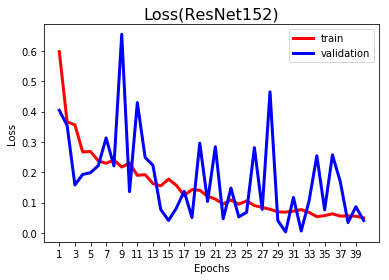

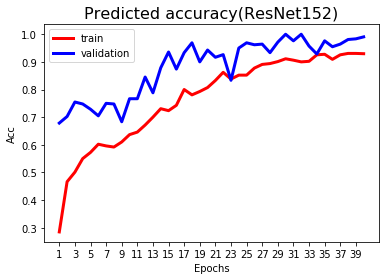

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

print('loss_train: ' + str(loss_train))
print('loss_val: ' + str(loss_val))
print('acc_train: ' + str(acc_train))
print('acc_val: ' + str(acc_val))

# 绘制第一个图，在一幅图上画两条曲线
plt.figure()
plt.title("Loss(ResNet152)",fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(1, 41, 2.0))
plt.plot(range(1,epochs + 1), loss_train,color='r', linewidth = 3.0, label='train')
plt.plot(range(1,epochs + 1), loss_val,color='b', linewidth = 3.0, label='validation')
plt.legend()  # 设置图例和其中的文本的显示

# 绘制第二个图，在一幅图上画两条曲线
plt.figure()
plt.title("Predicted accuracy(ResNet152)",fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.xticks(np.arange(1, 41, 2.0))
plt.plot(range(1,epochs + 1), acc_train,color='r', linewidth = 3.0, label='train')
plt.plot(range(1,epochs + 1), acc_val,color='b', linewidth = 3.0, label='validation')
plt.legend()  # 设置图例和其中的文本的显示

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 224, 224])
GroundTruth:     75    81    77    75
Predicted:     75    81    77    75


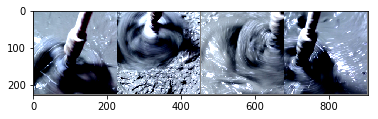

In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

classes = ('75', '77', '79', '81')

dataiter = iter(dataloders['validation'])
images, labels = dataiter.next()
print(images.size())
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[z]] for z in range(4)))

# test
outputs = model(images.cuda())
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[z]] for z in range(4)))

In [9]:
conc = {
    '0': '75  ',
    '1': '77  ',
    '2': '79  ',
    '3': '81  '
}

print("\t   Predicted\n")
print("\t   75\t77\t79\t81\n")
for i in range(0, num_classes):
    print("Actual ", end='')
    print(conc[str(i)], end='')
    for j in range(0, num_classes):
        print(str(best_matrix[i][j]) + '\t', end='')
    print('\n')

	   Predicted

	   75	77	79	81

Actual 75  105	0	0	0	

Actual 77  0	105	0	0	

Actual 79  0	0	105	0	

Actual 81  0	0	0	105	

